### Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### Wczytanie danych i wybór potrzebnych wartości

In [2]:
df_weather = pd.read_csv("data/weather.csv")
df_weather = df_weather[['timestamp', 'site_id', 'airTemperature' ]]
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather.describe()
df_weather

timestamp  site_id  airTemperature
0      2016-01-01 00:00:00  Panther            19.4
1      2016-01-01 01:00:00  Panther            21.1
2      2016-01-01 02:00:00  Panther            21.1
3      2016-01-01 03:00:00  Panther            20.6
4      2016-01-01 04:00:00  Panther            21.1
...                    ...      ...             ...
331161 2017-12-31 19:00:00    Mouse             8.5
331162 2017-12-31 20:00:00    Mouse             8.5
331163 2017-12-31 21:00:00    Mouse             8.2
331164 2017-12-31 22:00:00    Mouse             7.5
331165 2017-12-31 23:00:00    Mouse             7.2

[331166 rows x 3 columns]

In [3]:
df_meta = pd.read_csv("data/metadata.csv")

# Filtruj tylko wiersze, gdzie electricity == "Yes" i wybierz odpowiednie kolumny
df_meta = df_meta[['site_id', 'building_id', 'sqm', 'lat', 'lng', 'timezone', 'electricity', 'industry', 'yearbuilt', 'numberoffloors', 'occupants']][df_meta['electricity'] == "Yes"]
df_meta = df_meta.drop(columns=['electricity'])

# Grupowanie z odpowiednimi funkcjami agregującymi
df_grouped = df_meta.groupby(["site_id", "building_id"]).agg({
    'sqm': 'sum',  # Sumuj powierzchnię
    'lat': 'first',  # Weź pierwszą wartość (bez sumowania)
    'lng': 'first',  # Weź pierwszą wartość
    'timezone': 'first',  # Zachowaj tekst
    'industry': 'first',  # Zachowaj tekst
    'yearbuilt': 'first',  # Nie sumuj roku budowy
    'numberoffloors': 'first',  # Nie sumuj liczby pięter
    'occupants': 'first',  # Nie sumuj liczby osób
}).reset_index()  # Reset index, jeśli chcesz mieć site_id i building_id jako kolumny

df_grouped

site_id             building_id      sqm        lat         lng  \
0       Bear     Bear_assembly_Angel  22117.0  37.871903 -122.260729   
1       Bear  Bear_assembly_Beatrice   2802.0  37.871903 -122.260729   
2       Bear    Bear_assembly_Danial   7680.3  37.871903 -122.260729   
3       Bear     Bear_assembly_Diana    121.2  37.871903 -122.260729   
4       Bear     Bear_assembly_Genia  24256.1  37.871903 -122.260729   
...      ...                     ...      ...        ...         ...   
1573    Wolf       Wolf_public_Norma  23500.0  53.349800    6.260300   
1574    Wolf    Wolf_retail_Harriett   4108.0  53.349800    6.260300   
1575    Wolf    Wolf_retail_Marcella    363.0  53.349800    6.260300   
1576    Wolf      Wolf_retail_Toshia   4209.0  53.349800    6.260300   
1577    Wolf    Wolf_science_Alfreda    914.0  53.349800    6.260300   

           timezone   industry  yearbuilt  numberoffloors  occupants  
0        US/Pacific       None     1933.0             6.0        NaN  
1        US/Pacific       None     1958.0             4.0        NaN  
2        US/Pacific       None     2016.0             4.0        NaN  
3        US/Pacific       None     1995.0             1.0        NaN  
4        US/Pacific       None     1923.0             3.0        NaN  
...             ...        ...        ...             ...        ...  
1573  Europe/Dublin  Education        NaN             NaN        NaN  
1574  Europe/Dublin  Education        NaN             NaN        NaN  
1575  Europe/Dublin  Education        NaN             1.0        NaN  
1576  Europe/Dublin  Education        NaN             2.0        NaN  
1577  Europe/Dublin  Education        NaN             NaN        NaN  

[1578 rows x 10 columns]

In [4]:
df_electricity = pd.read_csv("data/electricity_cleaned.csv")
df_electricity.head()

timestamp  Panther_parking_Lorriane  Panther_lodging_Cora  \
0  2016-01-01 00:00:00                       NaN                   NaN   
1  2016-01-01 01:00:00                       NaN                   NaN   
2  2016-01-01 02:00:00                       NaN                   NaN   
3  2016-01-01 03:00:00                       NaN                   NaN   
4  2016-01-01 04:00:00                       NaN                   NaN   

   Panther_office_Hannah  Panther_lodging_Hattie  Panther_education_Teofila  \
0                    NaN                     NaN                        NaN   
1                    NaN                     NaN                        NaN   
2                    NaN                     NaN                        NaN   
3                    NaN                     NaN                        NaN   
4                    NaN                     NaN                        NaN   

   Panther_education_Jerome  Panther_retail_Felix  Panther_parking_Asia  \
0                       NaN                   NaN                   NaN   
1                       NaN                   NaN                   NaN   
2                       NaN                   NaN                   NaN   
3                       NaN                   NaN                   NaN   
4                       NaN                   NaN                   NaN   

   Panther_education_Misty  ...  Cockatoo_public_Caleb  \
0                      NaN  ...                123.200   
1                      NaN  ...                126.475   
2                      NaN  ...                127.825   
3                      NaN  ...                130.475   
4                      NaN  ...                129.675   

   Cockatoo_education_Tyler  Cockatoo_public_Shad  Mouse_health_Buddy  \
0                   727.575                69.200              8.8224   
1                   731.200                66.275             17.6449   
2                   724.675                64.675             17.6449   
3                   737.375                65.875             17.6449   
4                   721.150                66.275             17.6449   

   Mouse_health_Modesto  Mouse_lodging_Vicente  Mouse_health_Justin  \
0              370.0870                   10.0             282.9965   
1              737.8260                   30.0             574.9265   
2              729.9255                   30.0             570.2780   
3              722.2620                   20.0             561.1470   
4              719.1665                   30.0             564.3695   

   Mouse_health_Ileana  Mouse_health_Estela  Mouse_science_Micheal  
0                 26.0                135.0               168.2243  
1                 51.0                265.0               336.4486  
2                 50.0                272.0               336.4486  
3                 52.0                276.0               336.4486  
4                 50.0                280.0               336.4486  

[5 rows x 1579 columns]

In [5]:
df_electricity_long = df_electricity.melt(
    id_vars=['timestamp'],  # Kolumna z czasem
    var_name='building_id',  # Nazwy kolumn staną się wartościami w tej kolumnie
    value_name='energy_consumption'  # Wartości z kolumn trafią tutaj
)

# Połączenie z metadanymi
df_merged = pd.merge(
    df_electricity_long,
    df_meta,
    on='building_id',
    how='outer'  # Zachowaj wszystkie wiersze z df_electricity_long
)

# Usunięcie wierszy z brakującymi wartościami energy_consumption
df_merged = df_merged.dropna(subset=['energy_consumption'])

# Reset indeksu (opcjonalne)
df_merged = df_merged.reset_index(drop=True)

# Wynik
df_merged.head()

timestamp          building_id  energy_consumption site_id  \
0  2016-01-01 00:00:00  Bear_assembly_Angel              237.85    Bear   
1  2016-01-01 01:00:00  Bear_assembly_Angel              221.25    Bear   
2  2016-01-01 02:00:00  Bear_assembly_Angel              222.50    Bear   
3  2016-01-01 03:00:00  Bear_assembly_Angel              221.40    Bear   
4  2016-01-01 04:00:00  Bear_assembly_Angel              224.25    Bear   

       sqm        lat         lng    timezone industry  yearbuilt  \
0  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
1  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
2  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
3  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
4  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   

   numberoffloors  occupants  
0             6.0        NaN  
1             6.0        NaN  
2             6.0        NaN  
3             6.0        NaN  
4             6.0        NaN

In [6]:
df_merged.head()

timestamp          building_id  energy_consumption site_id  \
0  2016-01-01 00:00:00  Bear_assembly_Angel              237.85    Bear   
1  2016-01-01 01:00:00  Bear_assembly_Angel              221.25    Bear   
2  2016-01-01 02:00:00  Bear_assembly_Angel              222.50    Bear   
3  2016-01-01 03:00:00  Bear_assembly_Angel              221.40    Bear   
4  2016-01-01 04:00:00  Bear_assembly_Angel              224.25    Bear   

       sqm        lat         lng    timezone industry  yearbuilt  \
0  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
1  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
2  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
3  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   
4  22117.0  37.871903 -122.260729  US/Pacific      NaN     1933.0   

   numberoffloors  occupants  
0             6.0        NaN  
1             6.0        NaN  
2             6.0        NaN  
3             6.0        NaN  
4             6.0        NaN

In [7]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

# Połączenie danych
df_final = pd.merge(
    df_merged,
    df_weather,
    on=['timestamp', 'site_id'],
    how='left',
)

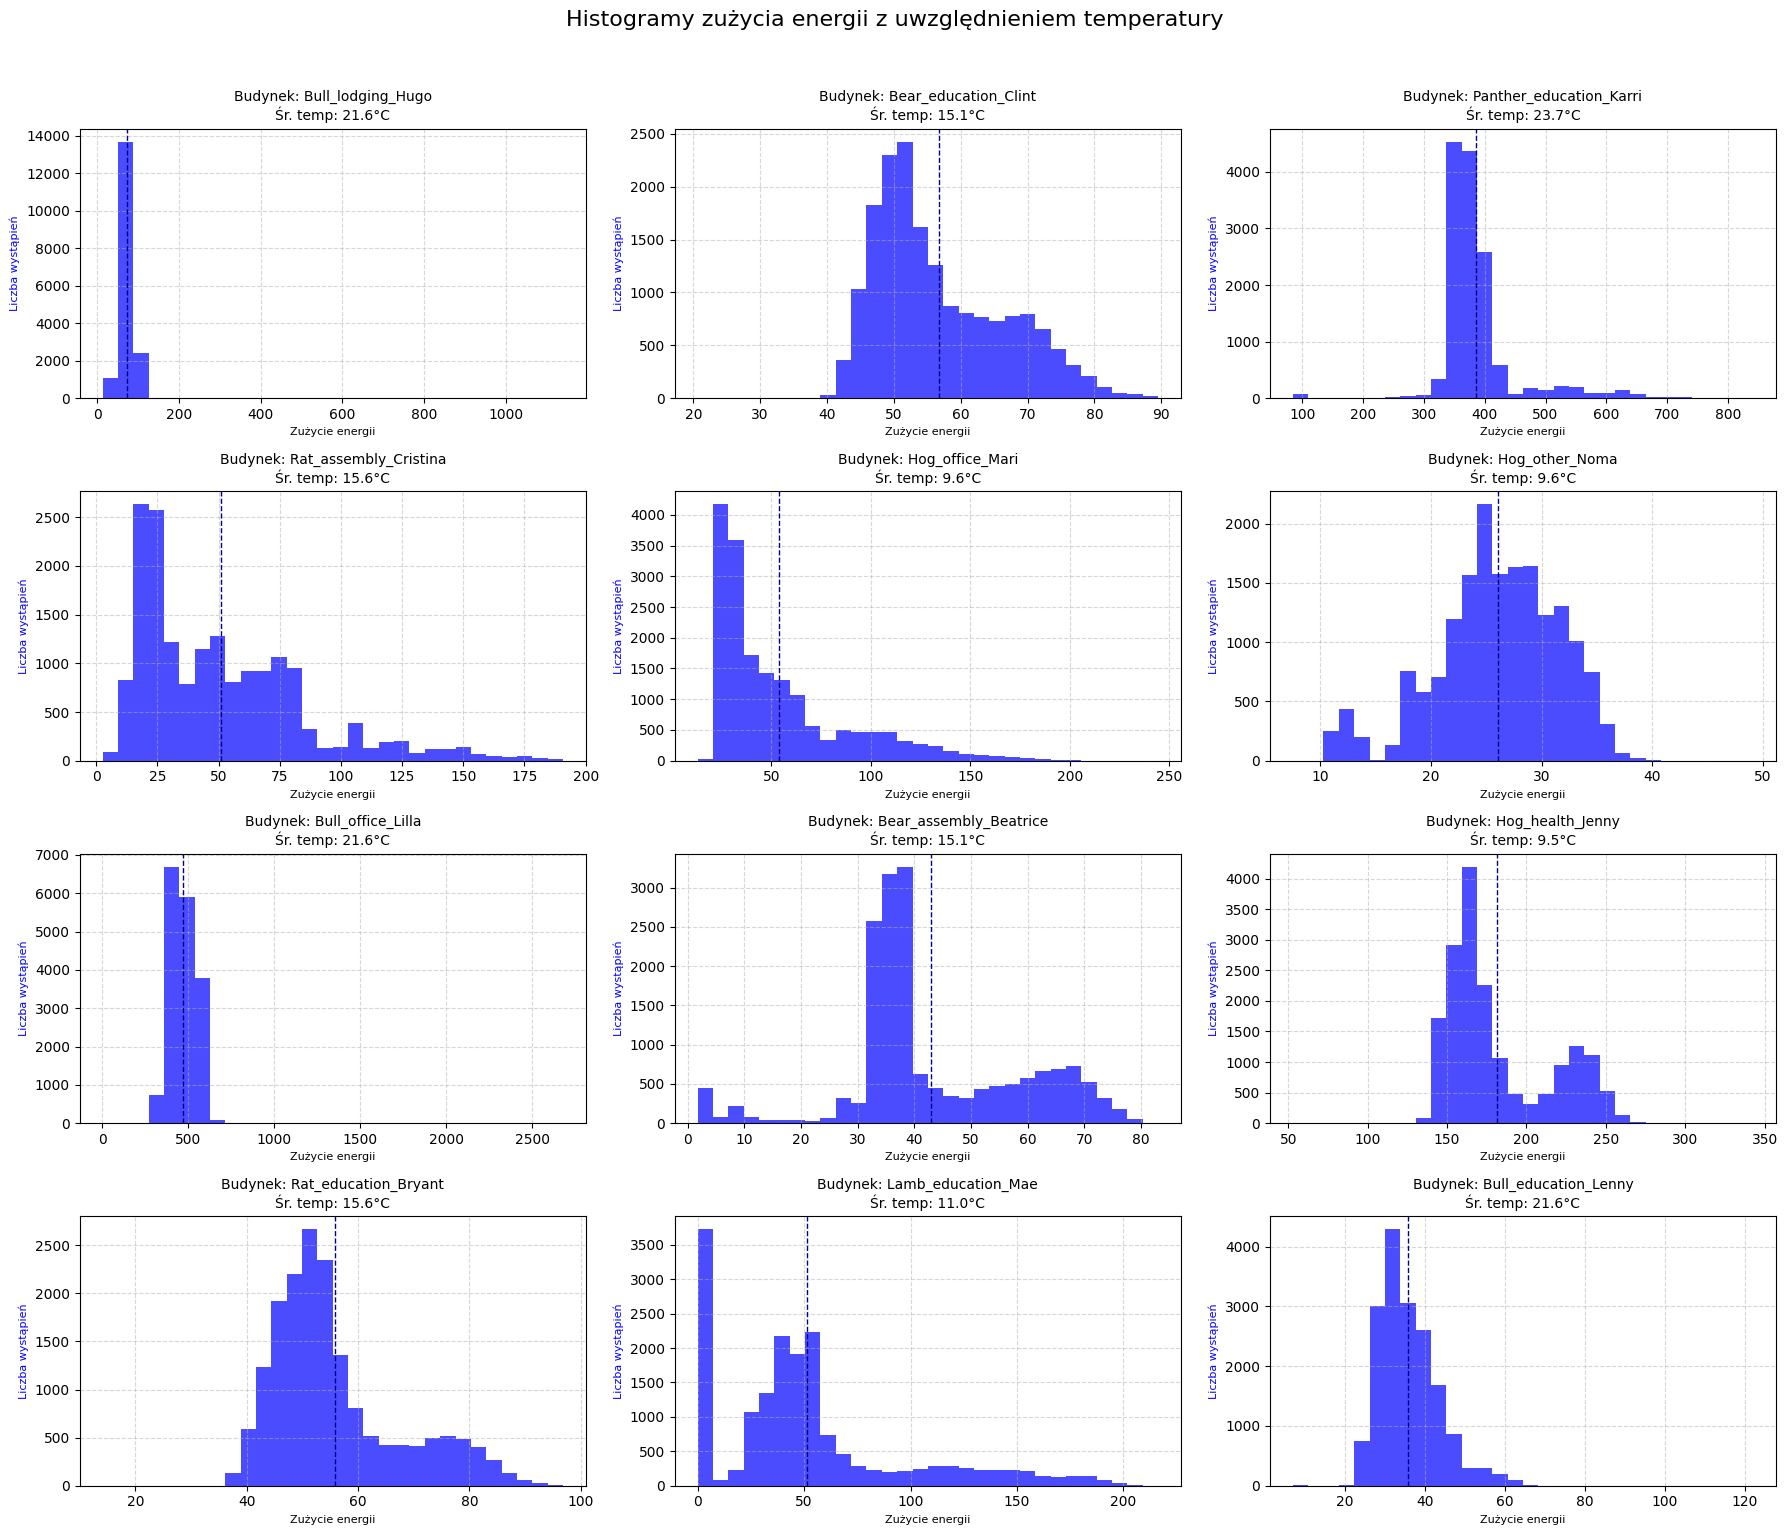

In [8]:
# 2. Wybór 12 losowych budynków
unique_buildings = df_final['building_id'].unique()
random_buildings = np.random.choice(unique_buildings, size=12, replace=False)

# 3. Przygotowanie wykresów
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
fig.suptitle('Histogramy zużycia energii z uwzględnieniem temperatury', fontsize=16, y=1.02)

for i, building_id in enumerate(random_buildings):
    # Dane dla wybranego budynku
    building_data = df_final[df_final['building_id'] == building_id]
    
    # Pozycja subplotu
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Histogram zużycia energii
    ax.hist(building_data['energy_consumption'], bins=30, color='blue', alpha=0.7)

    # Formatowanie
    ax.set_title(f'Budynek: {building_id}\nŚr. temp: {building_data["airTemperature"].mean():.1f}°C', fontsize=10)
    ax.set_xlabel('Zużycie energii', fontsize=8)
    ax.set_ylabel('Liczba wystąpień', fontsize=8, color='blue')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Linie średnich
    ax.axvline(building_data['energy_consumption'].mean(), color='darkblue', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


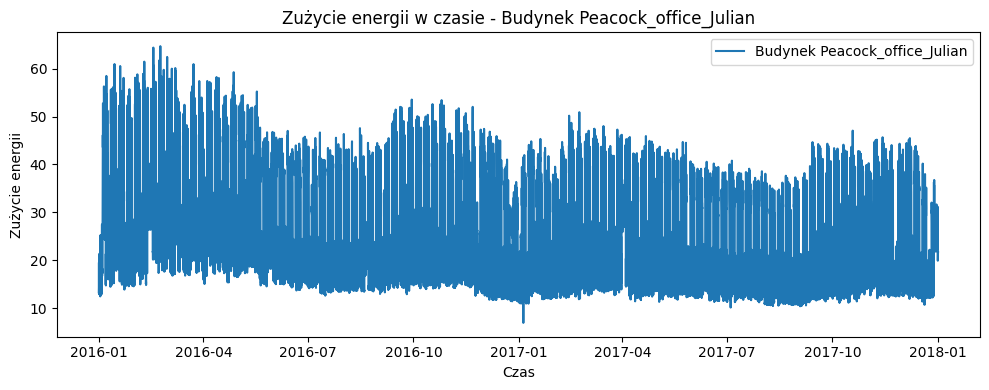

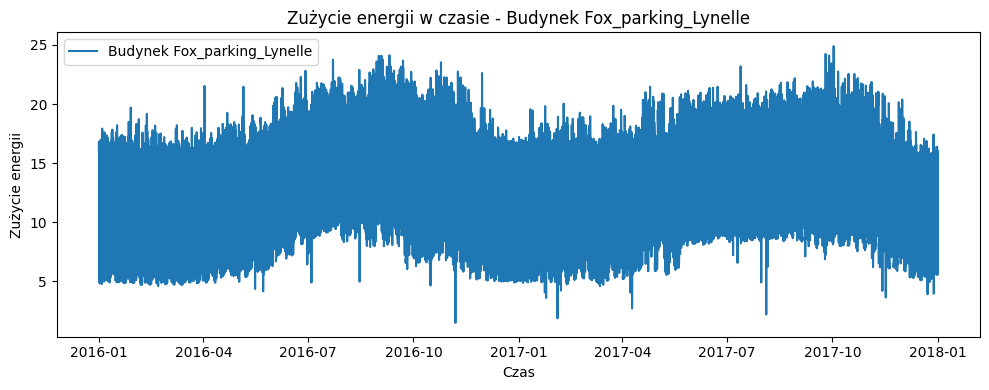

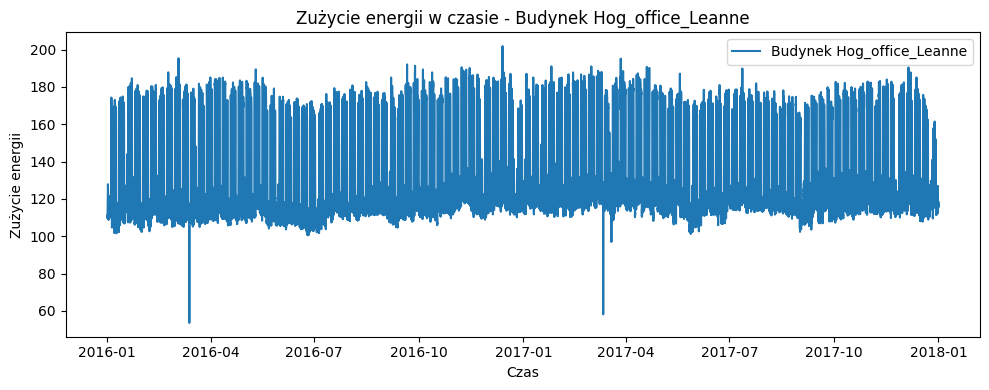

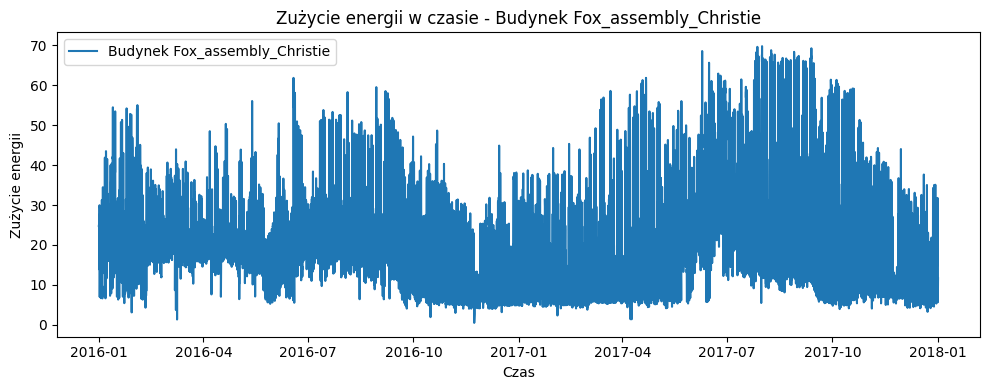

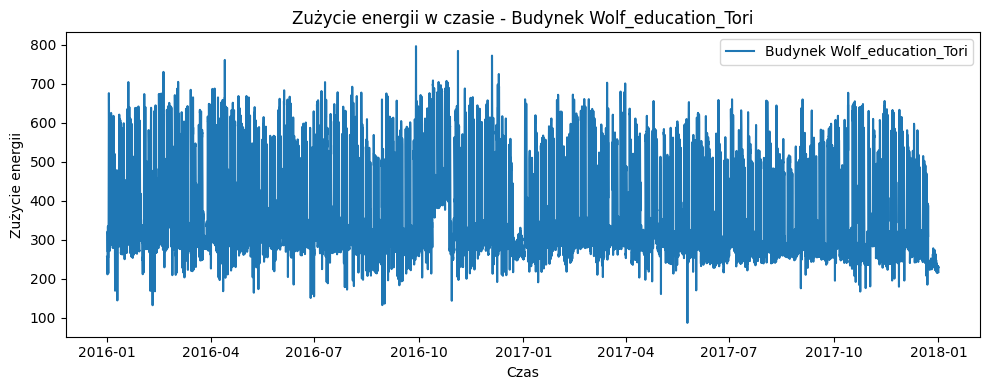

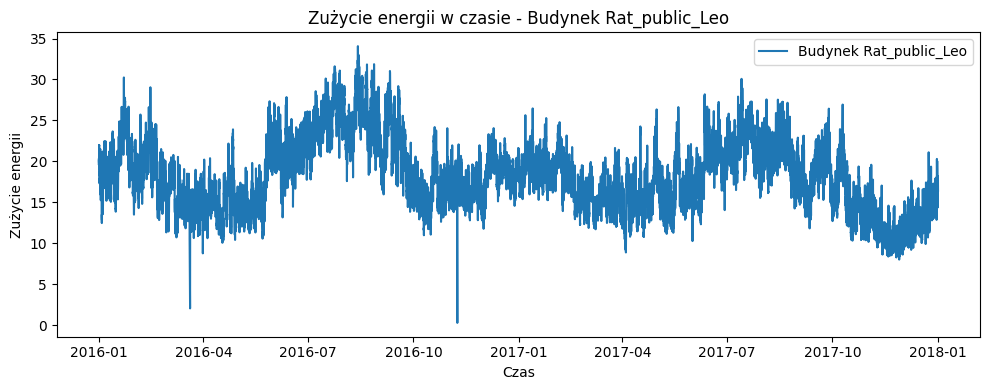

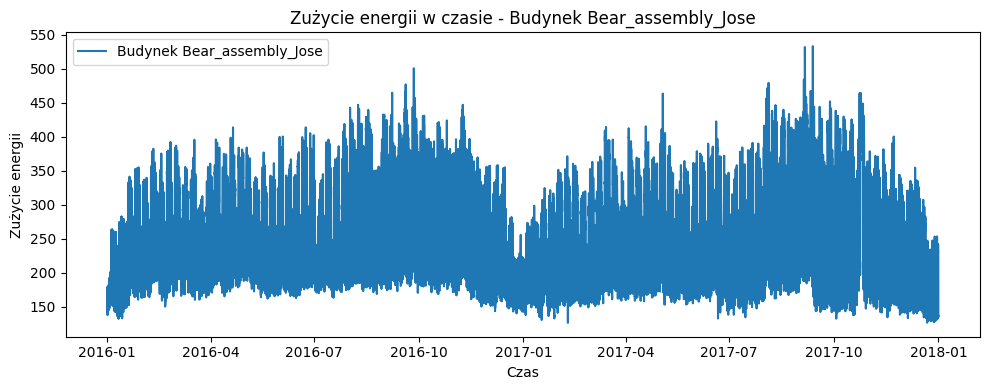

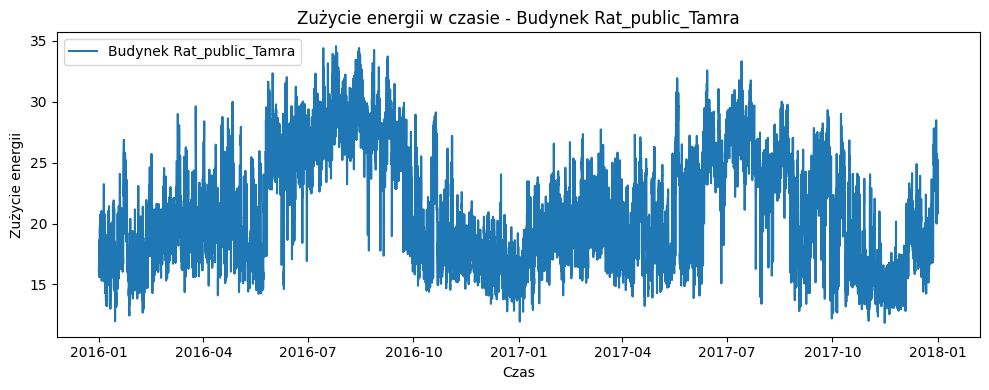

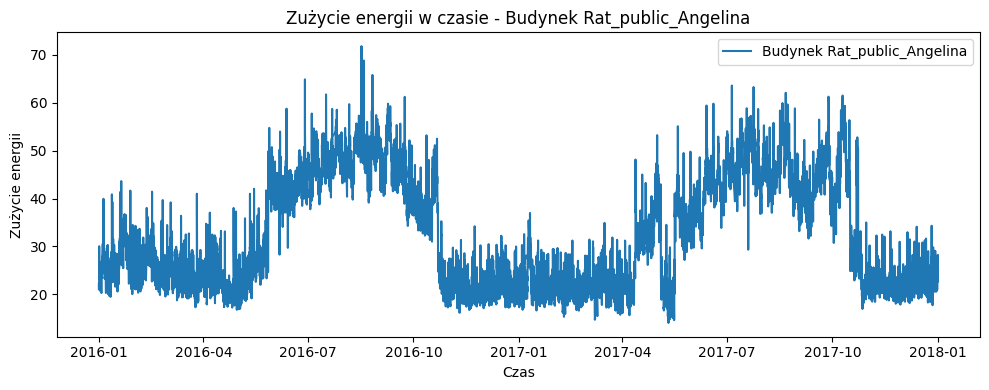

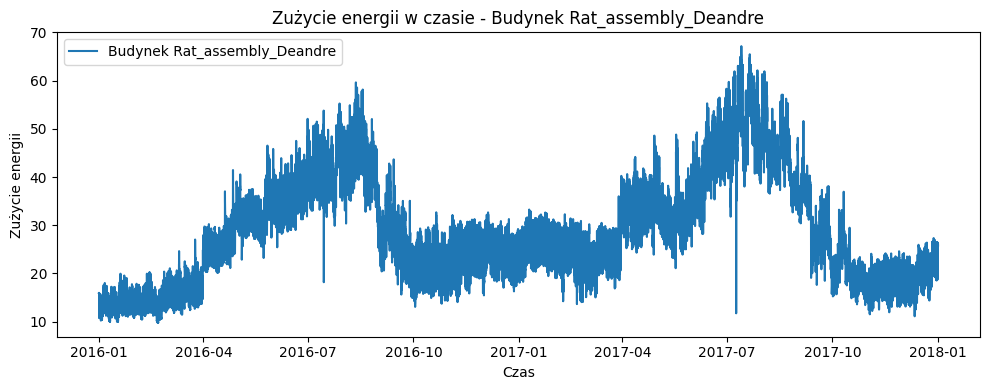

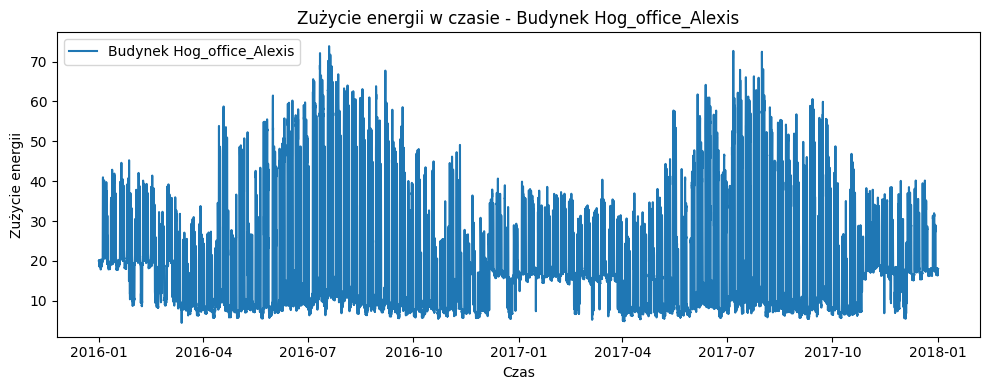

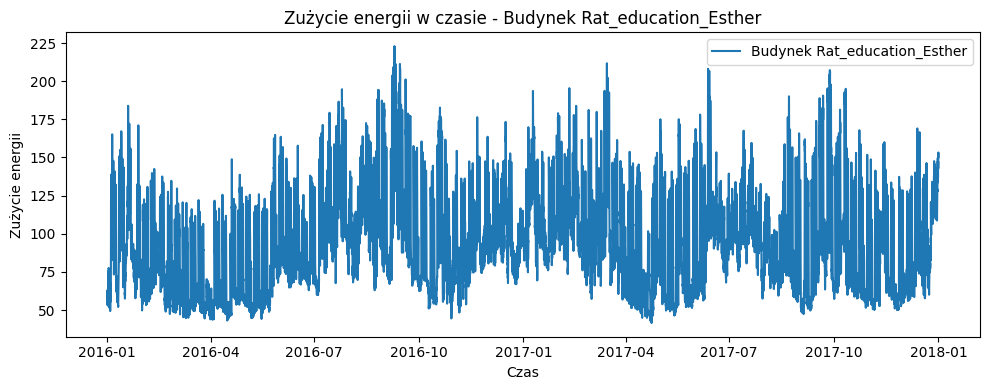

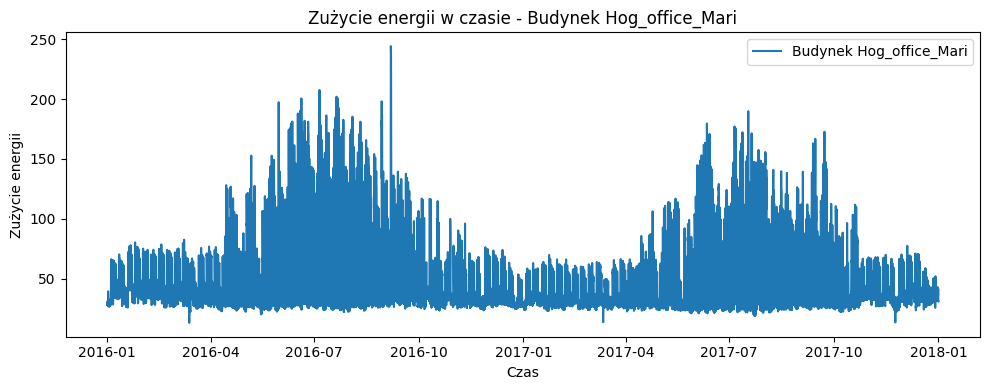

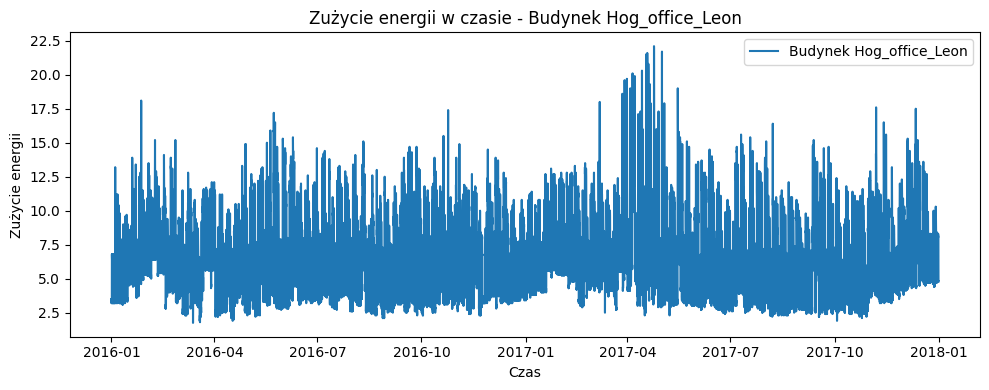

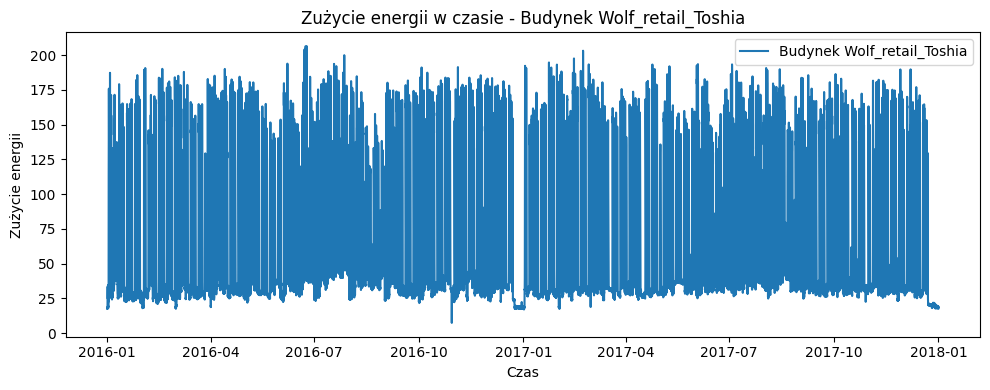

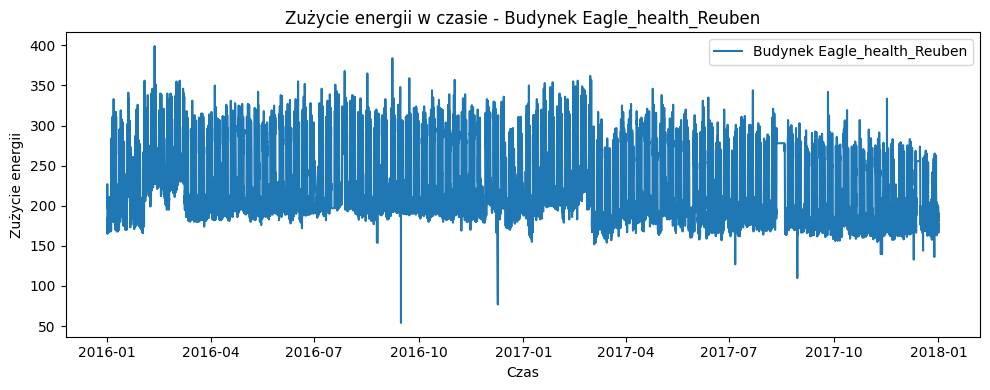

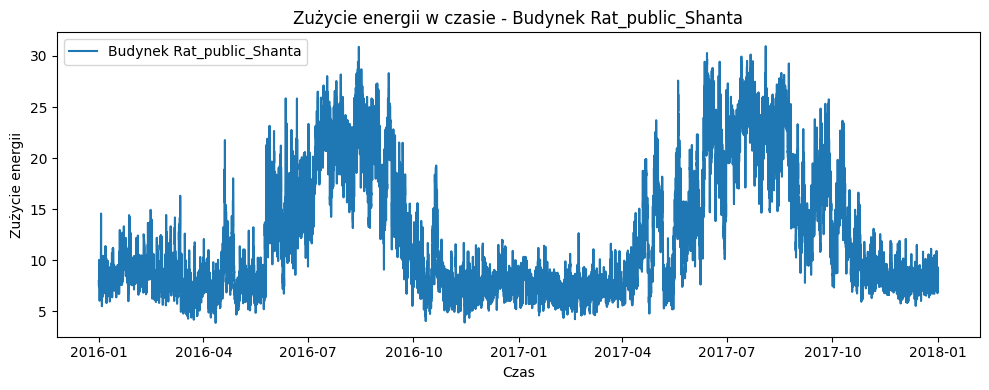

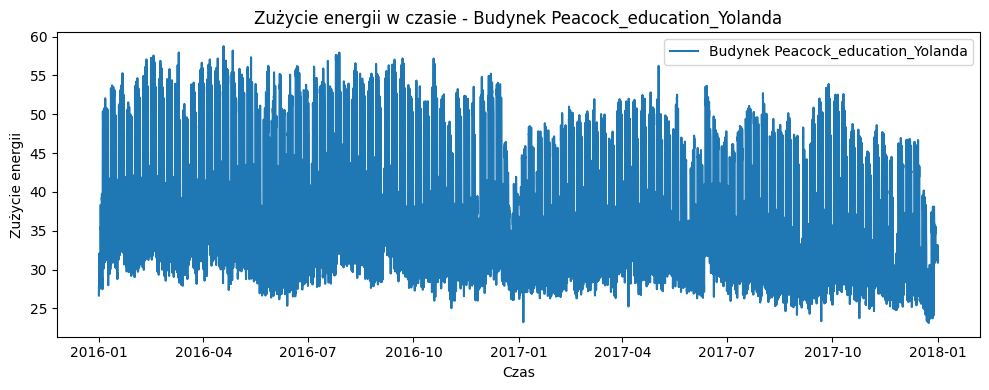

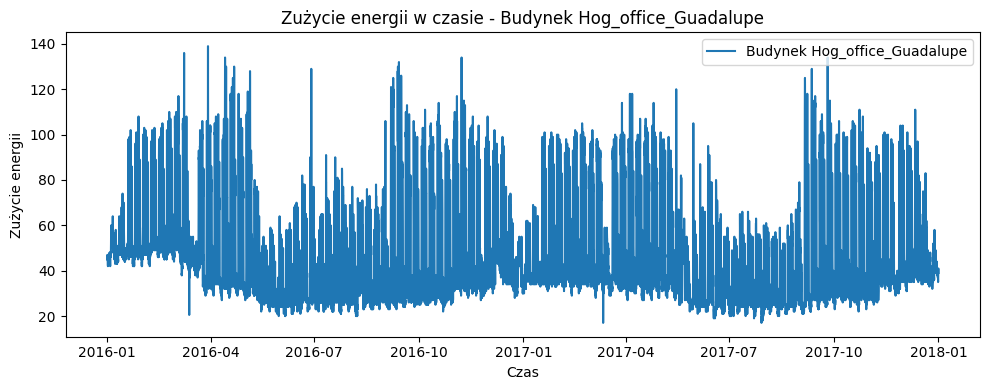

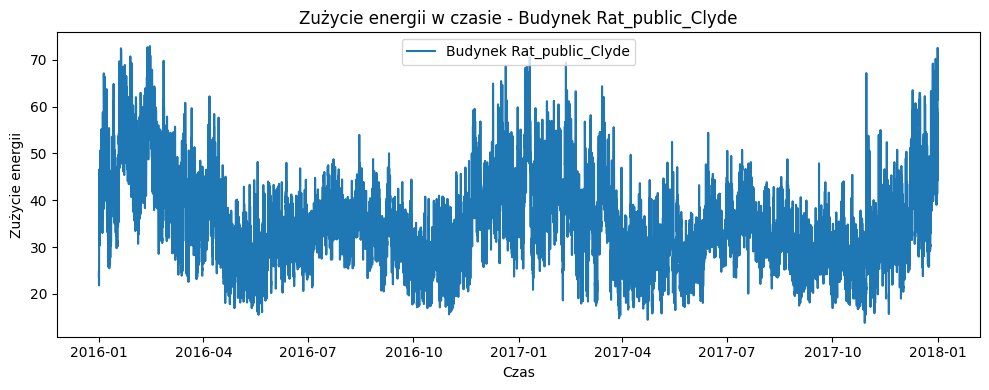

In [45]:
# 1. Wybór losowego budynku
import numpy as np

# 1. Losowe wybranie 20 unikalnych budynków
random_buildings = [
"Peacock_office_Julian",
"Fox_parking_Lynelle",
"Hog_office_Leanne",
"Fox_assembly_Christie",
"Wolf_education_Tori",
"Rat_public_Leo",
"Bear_assembly_Jose",
"Rat_public_Tamra",
"Rat_public_Angelina",
"Rat_assembly_Deandre",
"Hog_office_Alexis",
"Rat_education_Esther",
"Hog_office_Mari",
"Hog_office_Leon",
"Wolf_retail_Toshia",
"Eagle_health_Reuben",
"Rat_public_Shanta",
"Peacock_education_Yolanda",
"Hog_office_Guadalupe",
"Rat_public_Clyde",
]

df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])  # upewnij się, że to datetime
building_data = df_final[
    df_final['building_id'].isin(random_buildings)
].sort_values(['building_id', 'timestamp'])


for building_id in random_buildings:
    building_df = building_data[building_data['building_id'] == building_id]
    
    plt.figure(figsize=(10, 4))
    plt.plot(building_df['timestamp'], building_df['energy_consumption'], label=f'Budynek {building_id}')
    plt.xlabel('Czas')
    plt.ylabel('Zużycie energii')
    plt.title(f'Zużycie energii w czasie - Budynek {building_id}')
    plt.legend()
    plt.tight_layout()
    plt.show()

building_data.to_csv('test20set.csv', index=False)

### Analiza i preprocessing

In [10]:
df_final.describe()

timestamp  energy_consumption           sqm  \
count                       25212579        2.521258e+07  2.521258e+07   
mean   2017-01-05 02:23:47.485733120        1.449146e+02  8.411533e+03   
min              2016-01-01 00:00:00        1.000000e-04  2.630000e+01   
25%              2016-07-10 08:00:00        1.937500e+01  2.053200e+03   
50%              2017-01-06 02:00:00        5.957000e+01  5.261700e+03   
75%              2017-07-05 09:00:00        1.568667e+02  1.049800e+04   
max              2017-12-31 23:00:00        2.212280e+05  8.129010e+04   
std                              NaN        2.688494e+02  1.020827e+04   

                lat           lng     yearbuilt  numberoffloors     occupants  \
count  2.176336e+07  2.176336e+07  1.219226e+07    6.926062e+06  3.462585e+06   
mean   4.025139e+01 -7.373975e+01  1.966742e+03    3.673795e+00  2.804720e+02   
min    2.851769e+01 -1.222607e+02  1.900000e+03    1.000000e+00  0.000000e+00   
25%    3.342443e+01 -9.774310e+01  1.945000e+03    1.000000e+00  3.400000e+01   
50%    3.890350e+01 -7.700535e+01  1.969000e+03    2.000000e+00  1.000000e+02   
75%    4.497878e+01 -7.648529e+01  1.991000e+03    5.000000e+00  3.330000e+02   
max    5.334980e+01  6.260300e+00  2.017000e+03    2.600000e+01  2.380000e+03   
std    7.290676e+00  3.780838e+01  3.092296e+01    3.219477e+00  4.155114e+02   

       airTemperature  
count    2.511925e+07  
mean     1.568691e+01  
min     -2.890000e+01  
25%      8.900000e+00  
50%      1.610000e+01  
75%      2.330000e+01  
max      4.830000e+01  
std      1.026259e+01

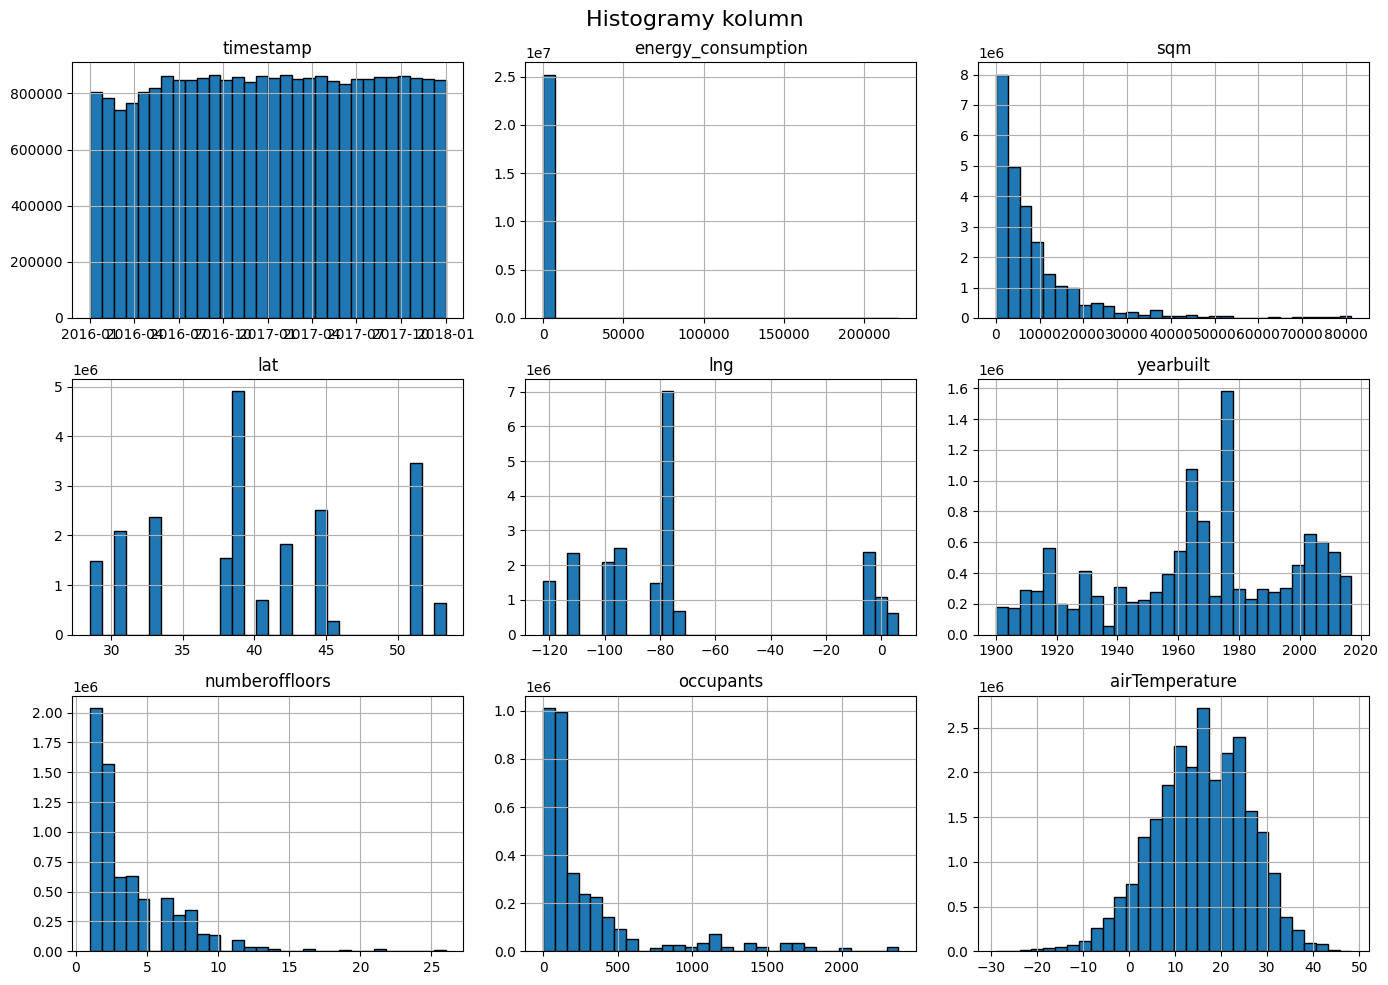

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Zakładam, że df_final jest już przygotowany i zawiera wskazane kolumny

# Histogramy
df_final.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)
plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
outliers = list(df_final['building_id'][df_final['energy_consumption'] >= 9000].unique())
len(outliers)

13

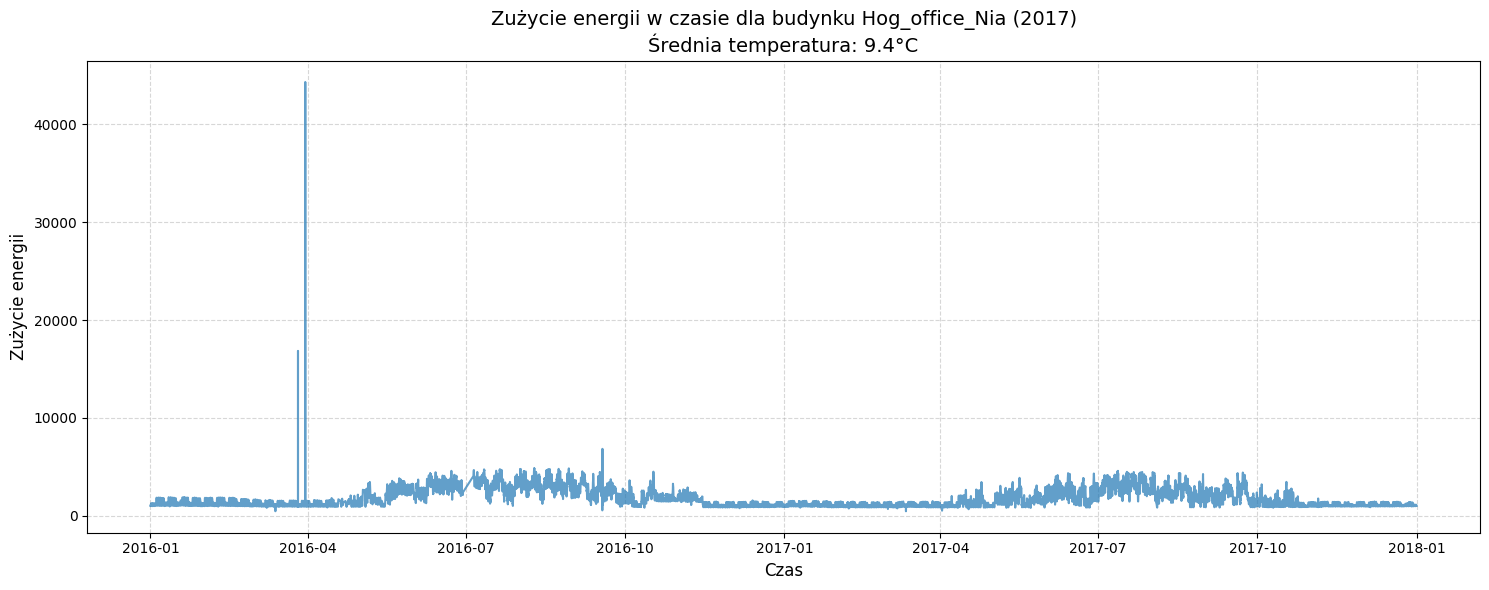

In [13]:
random_building = "Bull_education_Delia"
random_building = "Bull_assembly_Nick"
random_building = "Swan_unknown_Rudy"
random_building = "Hog_office_Nia"

# 2. Filtrowanie danych dla wybranego budynku i roku 2017
building_data = df_final[(df_final['building_id'] == random_building)].sort_values('timestamp')

# 3. Tworzenie wykresu scatter
plt.figure(figsize=(15, 6))
plt.plot(building_data['timestamp'], building_data['energy_consumption'], alpha=0.7)

# 4. Formatowanie wykresu
plt.title(f'Zużycie energii w czasie dla budynku {random_building} (2017)\n'
          f'Średnia temperatura: {building_data["airTemperature"].mean():.1f}°C', fontsize=14)
plt.xlabel('Czas', fontsize=12)
plt.ylabel('Zużycie energii', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# building_data.to_csv('anomaly_pseudo.csv', index=False)

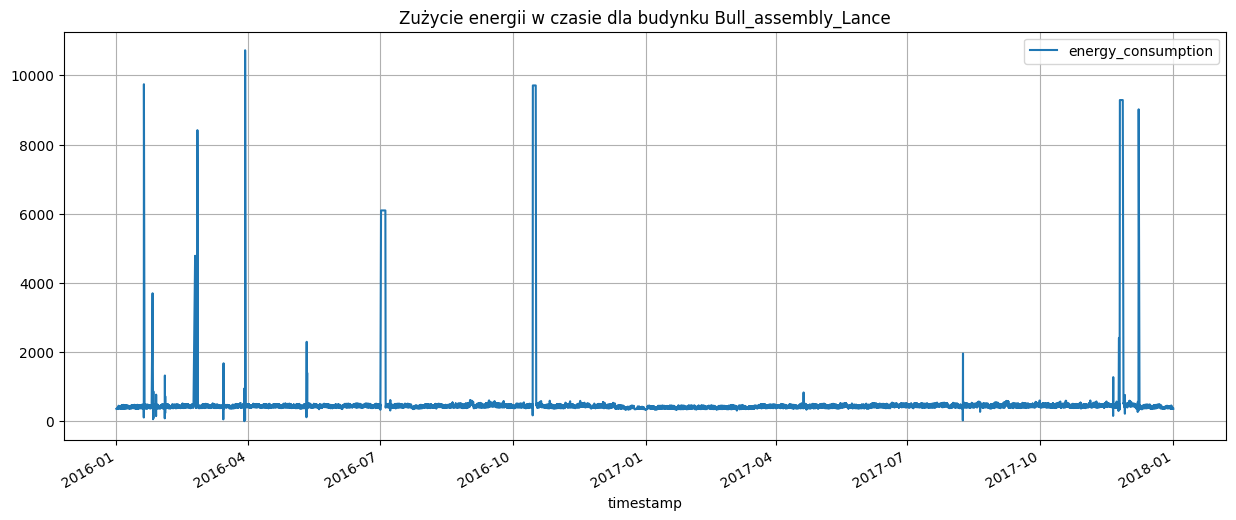

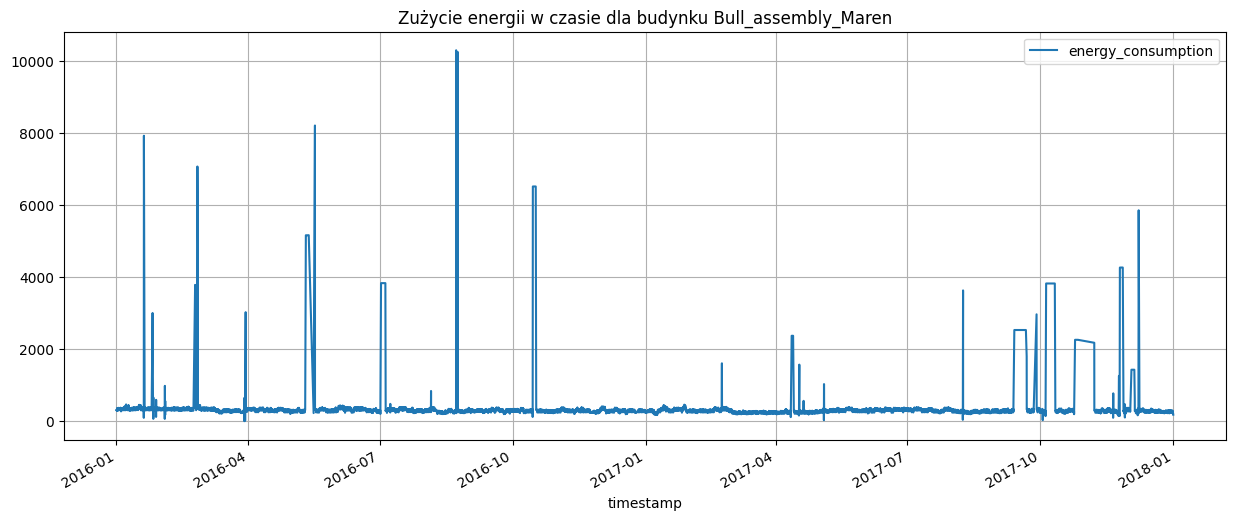

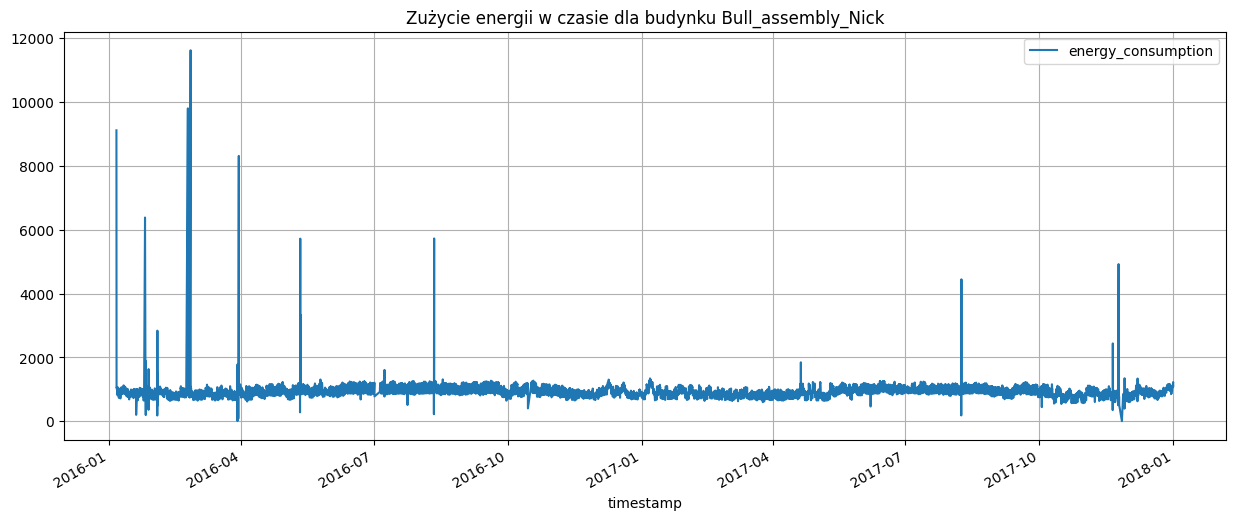

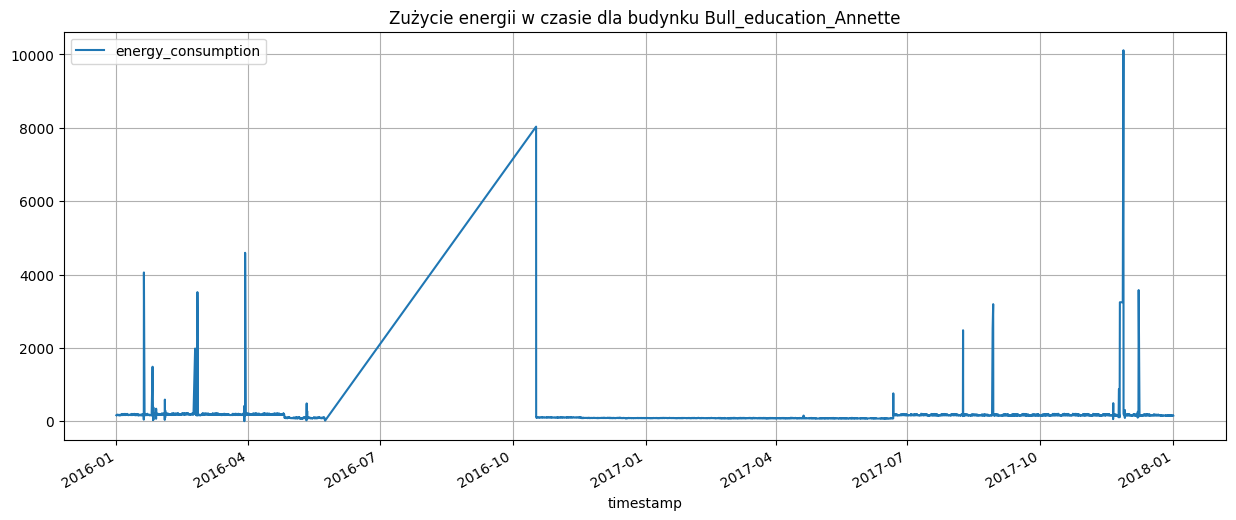

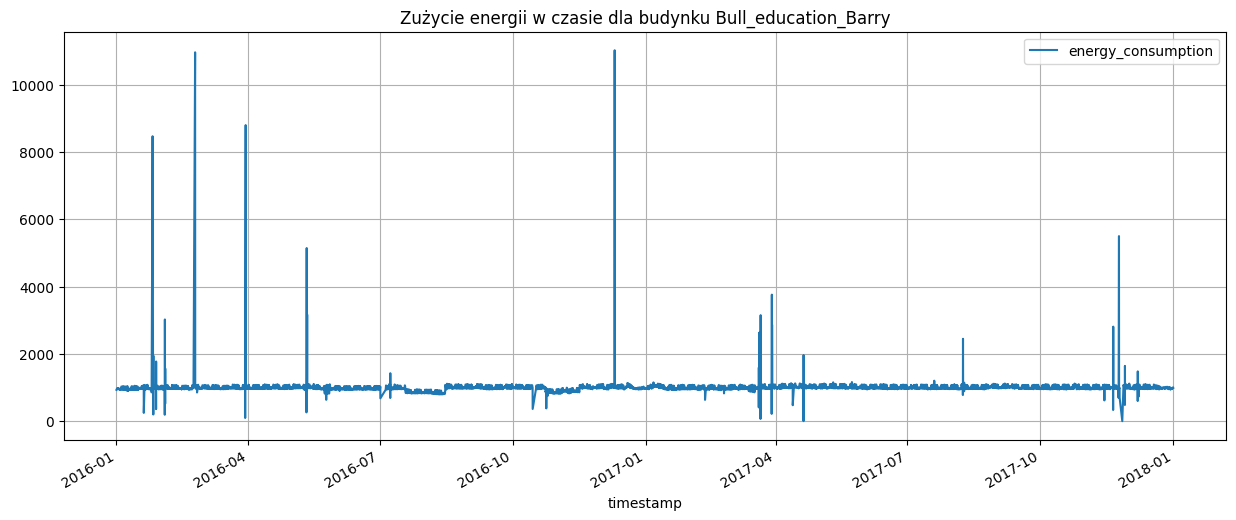

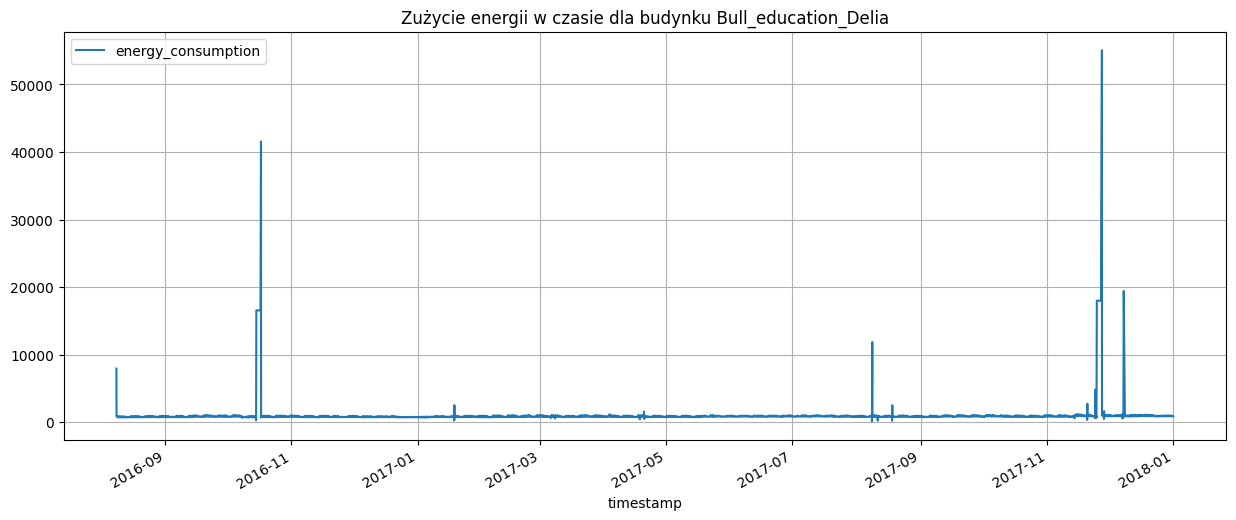

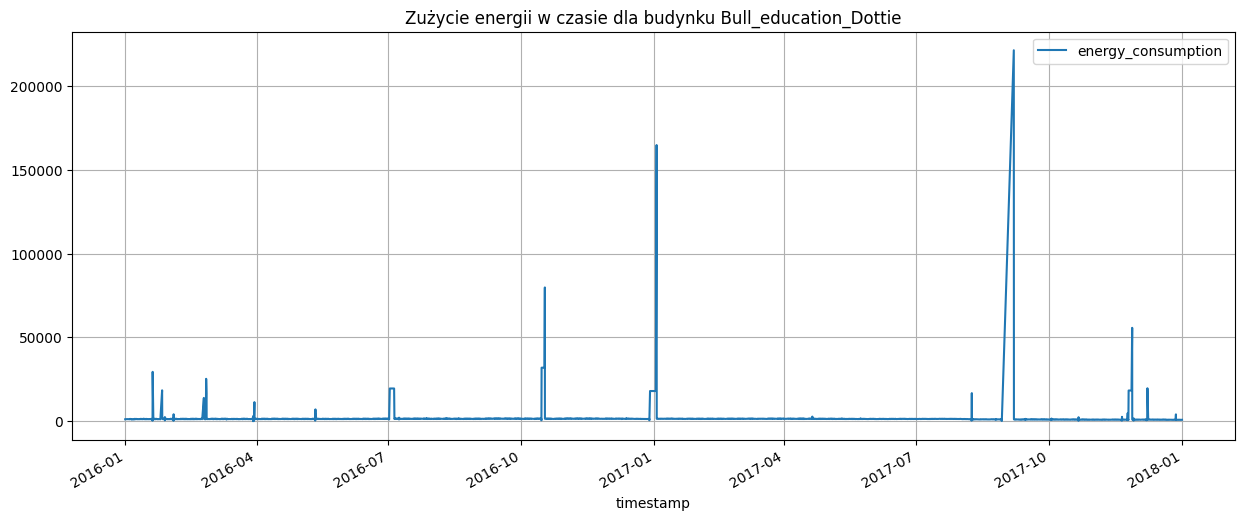

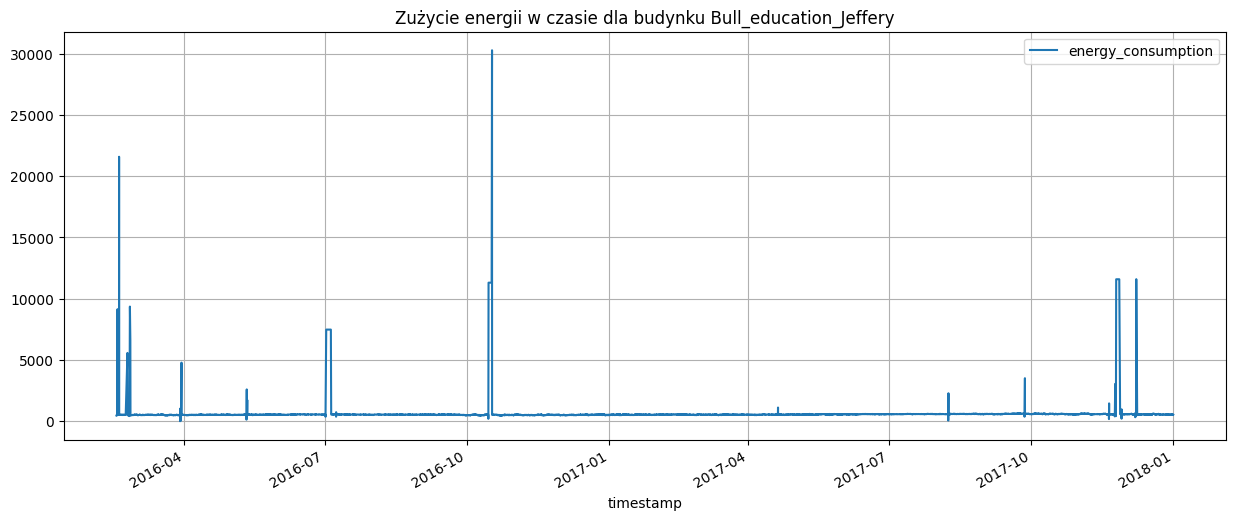

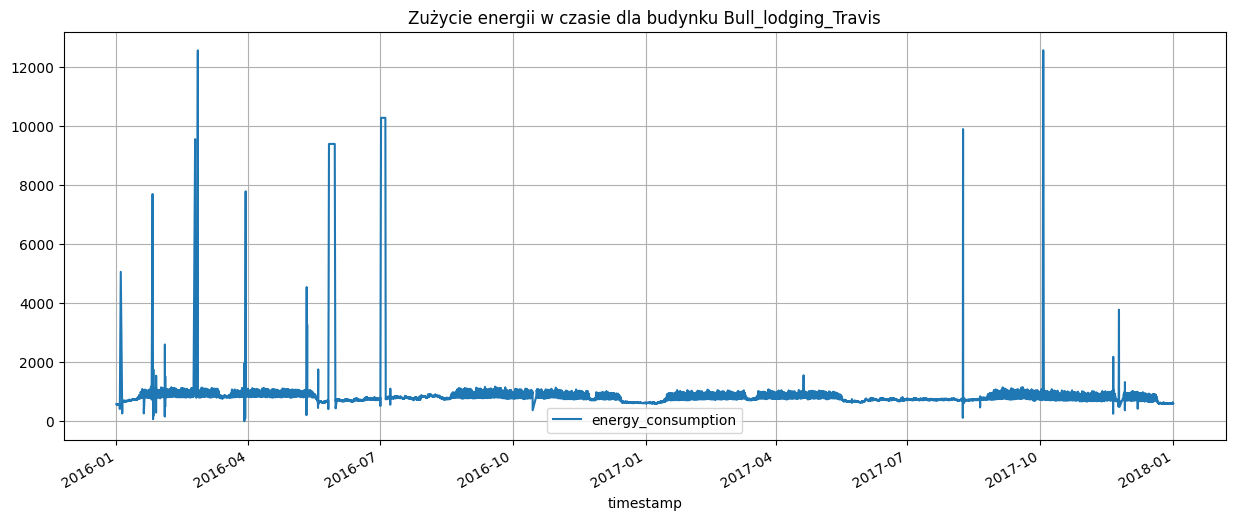

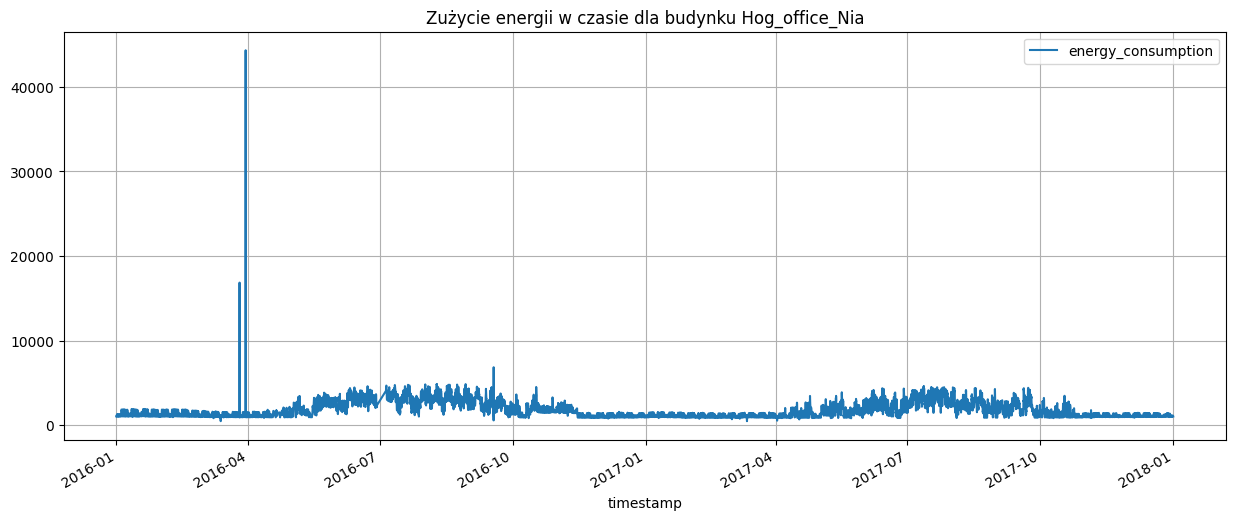

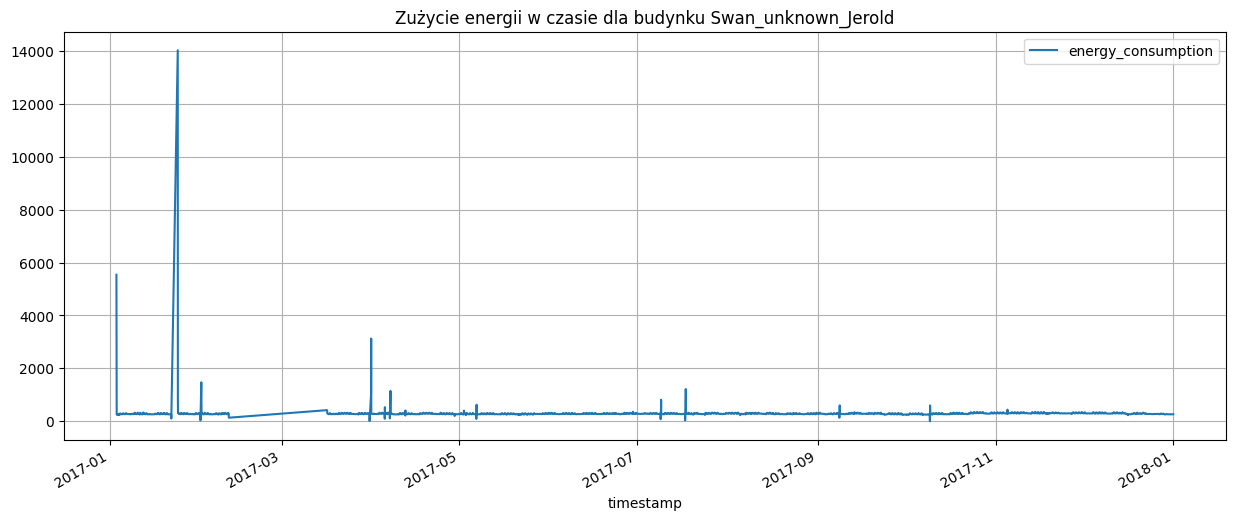

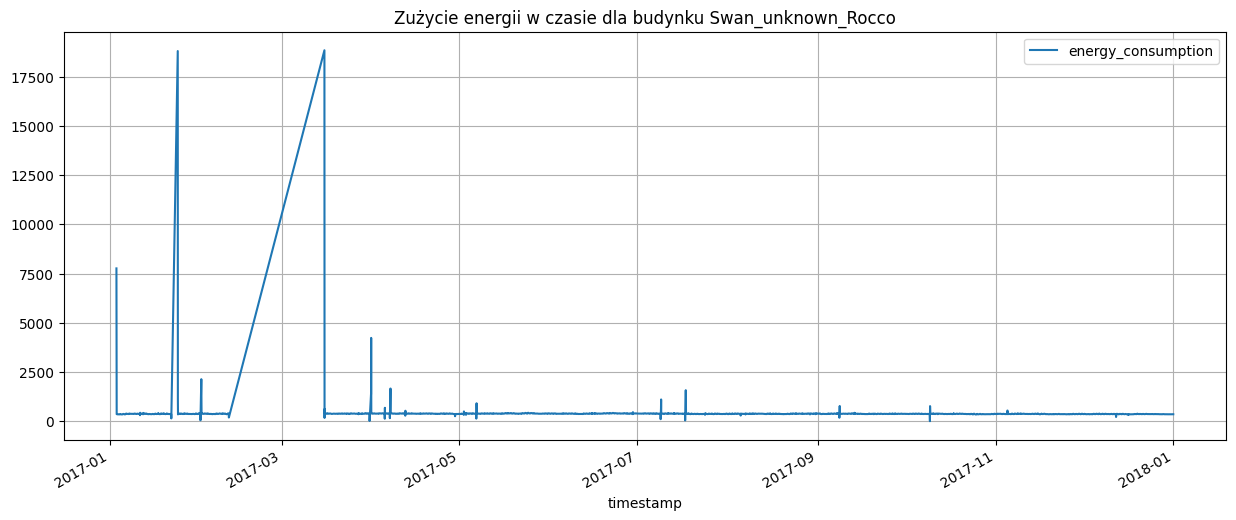

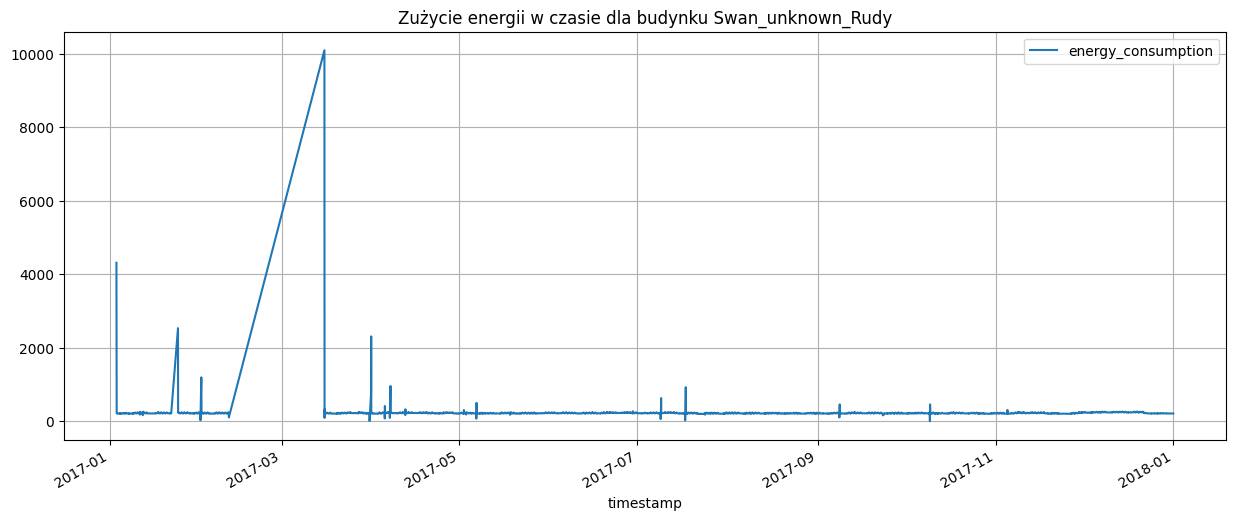

In [16]:
for out in outliers:
    bull = df_final[df_final['building_id'] == out]

    bull.plot(
        x='timestamp',
        y='energy_consumption',
        kind='line',
        figsize=(15, 6),
        title=f'Zużycie energii w czasie dla budynku {out}',
        grid=True
    )

    plt.show()

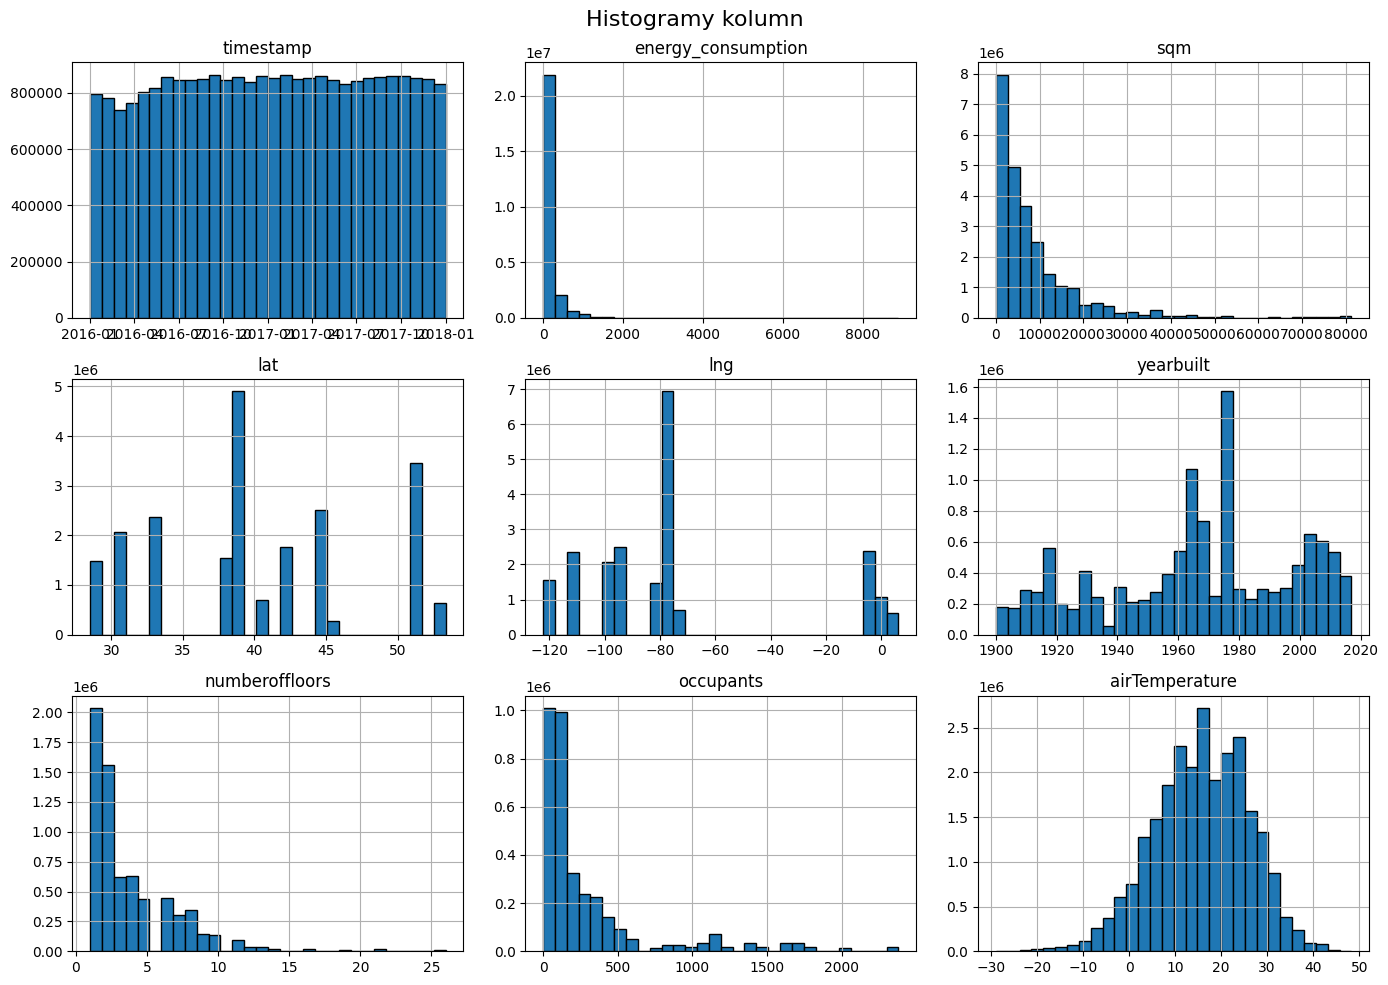

In [37]:
df_final = df_final[df_final['energy_consumption'] < 9000]
df_final = df_final.dropna(subset=['energy_consumption', 'sqm', 'airTemperature'])

df_final.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)

plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()

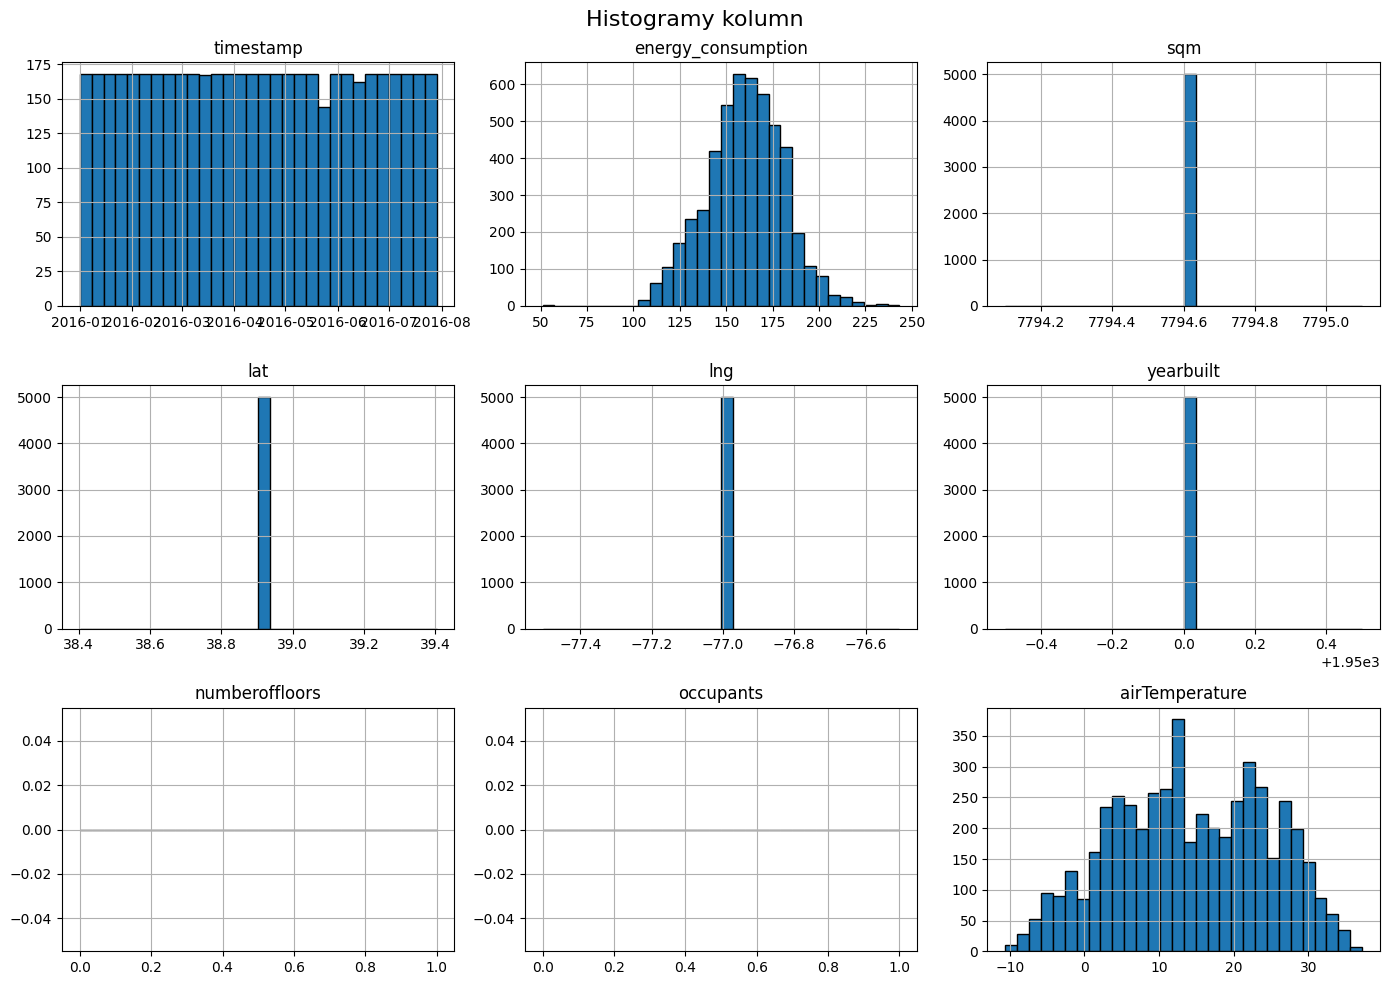

In [15]:
rat_df = df_final[df_final['building_id'] == "Rat_education_Moises"]

rat_df.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)

plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()

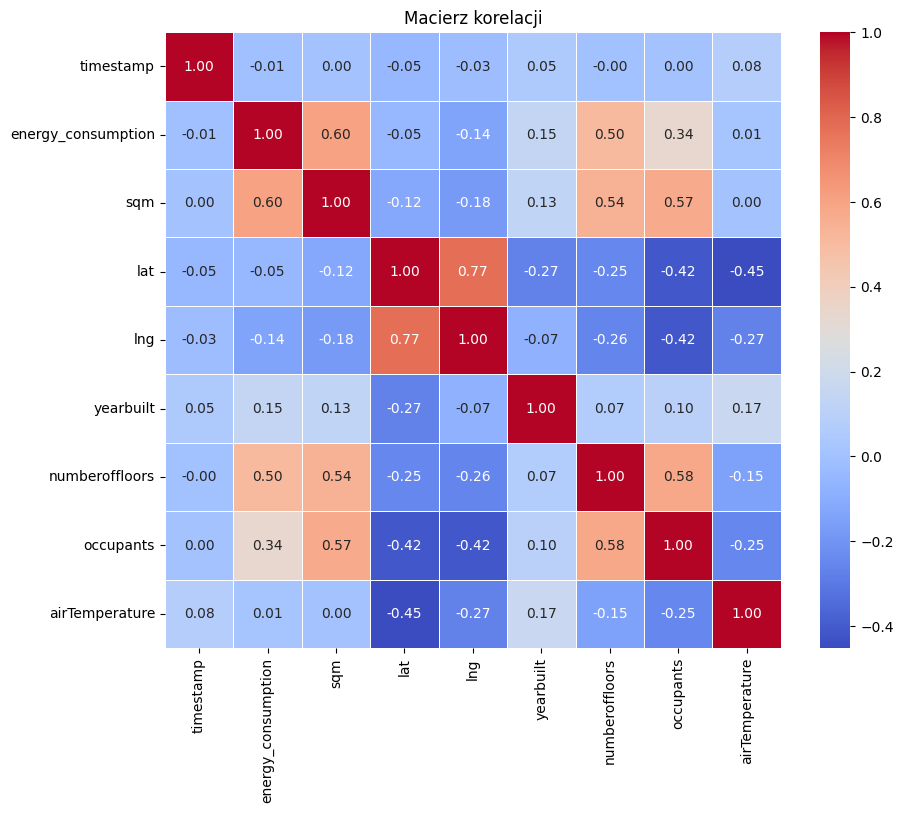

In [16]:
# Heatmapa korelacji
plt.figure(figsize=(10, 8))
corr_matrix = df_final.drop(columns=[ 'timezone', 'industry', 'building_id', 'site_id'])  # timestamp nie jest liczbowy
corr_matrix = corr_matrix.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    linewidths=0.5
)
plt.title('Macierz korelacji')
plt.show()


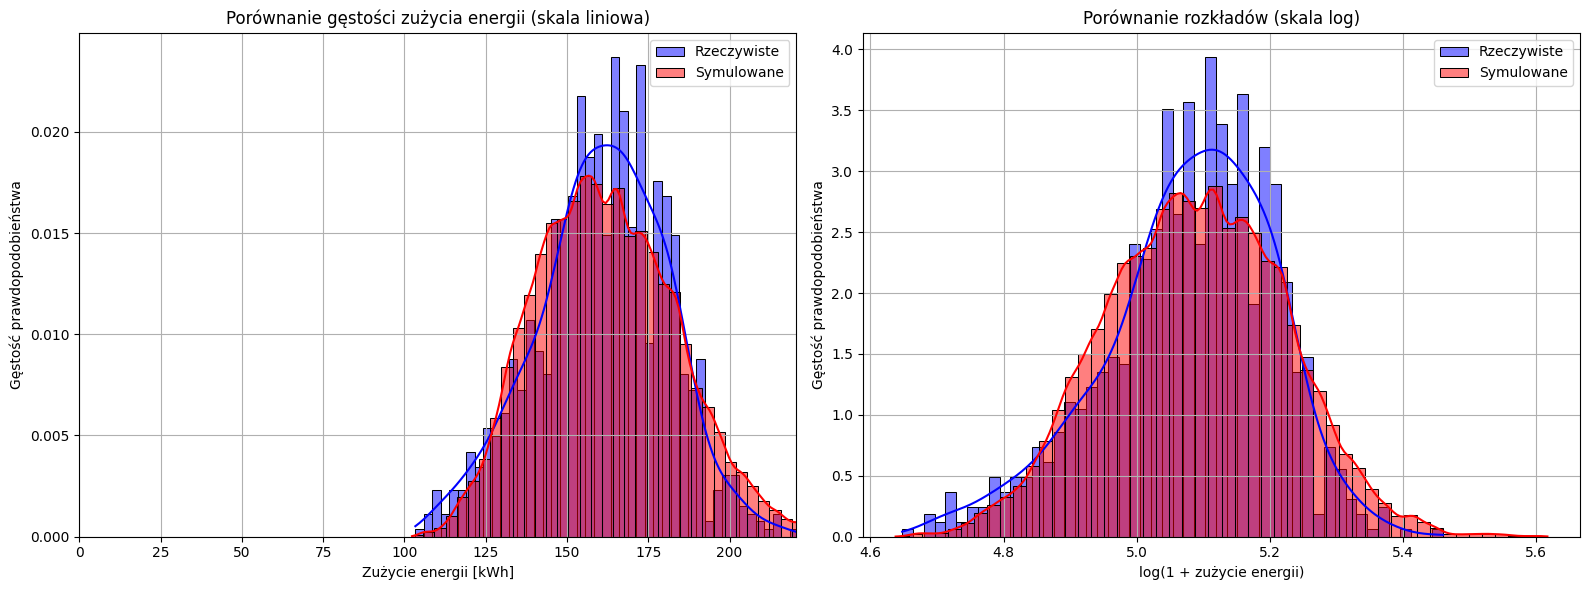

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Ustawienia stylu i rozmiaru wykresów
plt.rcParams['figure.figsize'] = (16, 6)

def calculate_density_comparison(real_data, simulated_data, max_points=10000):
    """
    Funkcja obliczająca i porównująca gęstości rozkładów
    """
    # Obliczanie zakresu dla wykresów
    combined_data = np.concatenate([real_data.reshape(-1), simulated_data.reshape(-1)])
    min_val = np.min(combined_data)
    max_val = np.percentile(combined_data, 99.9)
    
    # Obliczanie gęstości
    grid = np.linspace(min_val, max_val, 500)
    kde_real = gaussian_kde(real_data)(grid)
    kde_sim = gaussian_kde(simulated_data)(grid)
    
    return grid, kde_real, kde_sim

def simulate_from_prior(sqm, temp, num_samples=1000):
    log_sqm = np.log1p(sqm)  # Używamy log1p dla bezpieczeństwa
    log_sqm_scaled = (log_sqm - np.mean(log_sqm)) / np.std(log_sqm)
    temp_scaled = (temp - np.mean(temp)) / np.std(temp)
    
    # 2. Optymalne parametry modelu
    beta0 = np.random.normal(4.78, 0.1, num_samples)  # Średni poziom zużycia
    beta1 = np.random.normal(0.4, 0.1, num_samples)  # Wpływ powierzchni
    beta2 = np.random.normal(-0.1, 0.1, num_samples) # Wpływ temperatury
    sigma = np.random.lognormal(-5, 0.5, num_samples) # Kontrola rozrzutu
    
    # 3. Generowanie z nieliniowościami
    mu = beta0[:, None] + \
         beta1[:, None] * np.tanh(log_sqm_scaled) + \
         beta2[:, None] * temp_scaled * np.exp(-temp_scaled**2)  # Lokalne ekstremum
    
    # 4. Symulacja z obcięciem ekstremów
    simulated = np.exp(np.random.normal(mu, sigma[:, None]))
    simulated = np.minimum(simulated, 2000)  # Obcięcie ekstremalnych wartości
    
    return simulated.flatten()

# Przygotowanie danych
sample_size = 1000
clean_data = rat_df[["energy_consumption", "sqm", "airTemperature"]].dropna()

# Pobranie próbki zachowującej relacje między kolumnami
if len(clean_data) > sample_size:
    real_sample = clean_data.sample(n=sample_size, random_state=42)
else:
    real_sample = clean_data.copy()

# Wydzielenie kolumn
real_energy = real_sample["energy_consumption"].values
sqm = real_sample["sqm"].values
temp = real_sample["airTemperature"].values

# Generowanie symulowanych danych
simulated_data = simulate_from_prior(sqm, temp)

# Tworzenie wykresów
fig, (ax1, ax2) = plt.subplots(1, 2)

# Wykres 1: Skala liniowa
sns.histplot(real_energy, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax1, stat='density', kde=True)
sns.histplot(simulated_data, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax1, stat='density', kde=True)
ax1.set_title('Porównanie gęstości zużycia energii (skala liniowa)')
ax1.set_xlabel('Zużycie energii [kWh]')
ax1.set_ylabel('Gęstość prawdopodobieństwa')
ax1.legend()
ax1.grid(True)

combined = np.concatenate([real_energy, simulated_data])
ax1.set_xlim(0, np.percentile(combined, 99))

log_real = np.log1p(real_energy)
log_sim = np.log1p(simulated_data)

sns.histplot(log_real, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax2, stat='density', kde=True)
sns.histplot(log_sim, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax2, stat='density', kde=True)
ax2.set_title('Porównanie rozkładów (skala log)')
ax2.set_xlabel('log(1 + zużycie energii)')
ax2.set_ylabel('Gęstość prawdopodobieństwa')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [37]:

# # "Gator_assembly_Bailey" ----> typowo mały budynek <100 m2

### Modele

In [18]:
import os
# Zakładamy, że mamy kolumnę np. "energy"
# df_subset = df_final[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()
df_subset = rat_df[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()

# Creating models
N = len(df_subset)
df_subset = df_subset.iloc[:N]

model_prior = CmdStanModel(stan_file='not_full_data_models/prior.stan', force_compile=True )

temp = df_subset['airTemperature']
sqm	= df_subset['sqm']

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm}

# Sampling z priora
prior_1 = model_prior.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    output_dir="stan_output",
    fixed_param=True,
    refresh=100,
)

# Odczyt wyników
prior_df = prior_1.draws_pd()
prior_df.head()


15:50:04 - cmdstanpy - INFO - compiling stan file C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\not_full_data_models\prior.stan to exe file C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\not_full_data_models\prior.exe
15:50:24 - cmdstanpy - INFO - compiled model executable: C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\not_full_data_models\prior.exe
15:50:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:50:41 - cmdstanpy - INFO - CmdStan done processing.


chain__  iter__  draw__  lp__  accept_stat__  y_sim[1]  y_sim[2]  y_sim[3]  \
0      1.0     1.0     1.0   0.0            0.0   63.4568   99.1013   82.0754   
1      1.0     2.0     2.0   0.0            0.0   99.0539   80.9144   86.7036   
2      1.0     3.0     3.0   0.0            0.0   85.2432  100.3670  109.5990   
3      1.0     4.0     4.0   0.0            0.0  113.0060  100.1600  104.3720   
4      1.0     5.0     5.0   0.0            0.0   88.7802   98.0210   89.9895   

   y_sim[4]  y_sim[5]  ...  y_sim[4993]  y_sim[4994]  y_sim[4995]  \
0   81.5111   94.0664  ...     107.9920      85.3825      90.1899   
1   77.8356   85.7510  ...      87.7132      90.1458      97.1347   
2   81.1007   84.1620  ...      79.0708      88.8276      80.1671   
3   85.8379   85.0107  ...      71.9528      98.2324      84.5054   
4   97.6783   97.2984  ...     105.0670      80.4031      75.3826   

   y_sim[4996]  y_sim[4997]  y_sim[4998]  y_sim[4999]  y_sim[5000]  \
0      83.6017     105.1210      89.5262      79.1784      88.7504   
1     102.3750      87.1011      93.0595     121.6410      80.3296   
2      77.5848      81.0254      81.5801      86.1670      67.1725   
3      93.2519      70.6150      92.5888      81.8659      91.5984   
4      70.3324      78.7759      86.6359      92.7325      91.6115   

   y_sim[5001]  y_sim[5002]  
0      76.9731     113.3270  
1      86.1197      70.9253  
2     103.6870     100.8960  
3      82.9219      90.8826  
4      92.8875      73.5784  

[5 rows x 5007 columns]

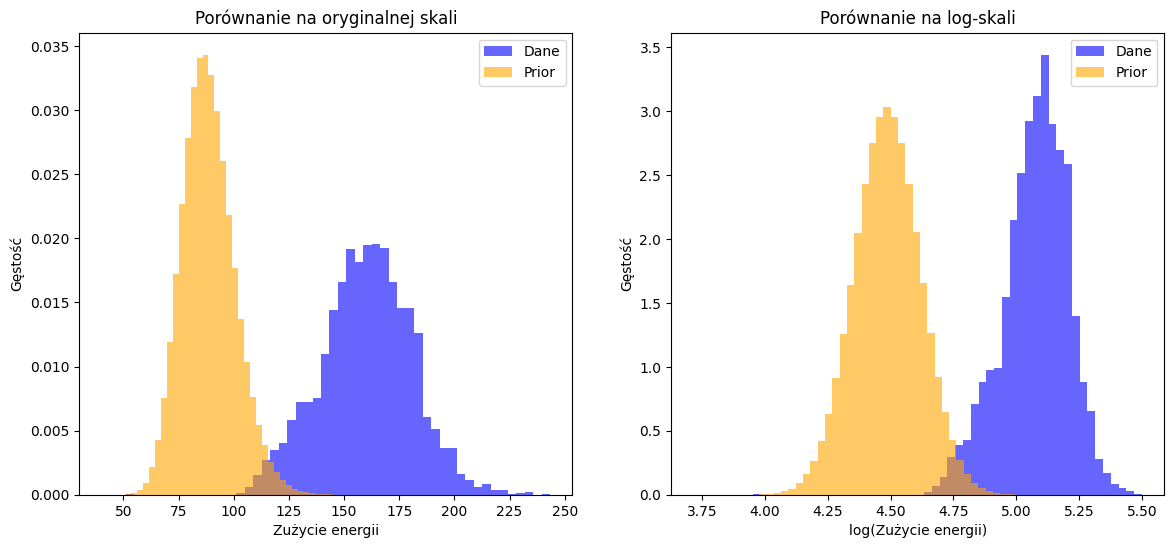

In [19]:
prior_samples = prior_1.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title("Porównanie na oryginalnej skali")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(rat_df["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(prior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")

plt.show()


In [44]:
prior_df.describe()

chain__       iter__       draw__    lp__  accept_stat__     y_sim[1]  \
count   1000.0  1000.000000  1000.000000  1000.0         1000.0  1000.000000   
mean       1.0   500.500000   500.500000     0.0            0.0    93.217310   
std        0.0   288.819436   288.819436     0.0            0.0    12.594814   
min        1.0     1.000000     1.000000     0.0            0.0    62.407600   
25%        1.0   250.750000   250.750000     0.0            0.0    84.454275   
50%        1.0   500.500000   500.500000     0.0            0.0    93.146950   
75%        1.0   750.250000   750.250000     0.0            0.0   100.935250   
max        1.0  1000.000000  1000.000000     0.0            0.0   140.099000   

          y_sim[2]     y_sim[3]     y_sim[4]     y_sim[5]  ...  y_sim[4993]  \
count  1000.000000  1000.000000  1000.000000  1000.000000  ...  1000.000000   
mean     92.012143    92.339817    92.650965    92.284150  ...    88.061912   
std      12.663827    12.647267    12.447530    12.446347  ...    11.219980   
min      59.164600    61.324000    60.080100    60.426900  ...    58.727600   
25%      83.391675    83.452375    84.290350    83.903300  ...    79.879325   
50%      91.045500    91.158850    91.247000    91.563200  ...    87.409300   
75%      99.329725   100.126000   100.081250    99.820725  ...    95.072575   
max     140.553000   146.096000   140.745000   137.089000  ...   132.119000   

       y_sim[4994]  y_sim[4995]  y_sim[4996]  y_sim[4997]  y_sim[4998]  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     88.035399    86.715714    86.284233    86.252384    85.906299   
std      11.009580    10.846604    11.751957    11.504695    11.283702   
min      59.713500    61.417400    49.870500    55.878500    56.764700   
25%      80.363875    78.917250    77.960925    78.375900    77.934900   
50%      87.525750    86.383350    85.150550    85.796450    85.249950   
75%      94.951150    93.782350    94.028450    92.941700    93.104825   
max     127.798000   136.156000   126.037000   137.493000   132.091000   

       y_sim[4999]  y_sim[5000]  y_sim[5001]  y_sim[5002]  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean     85.543425    86.065958    86.394741    85.482368  
std      11.512087    11.385550    11.577519    10.615147  
min      53.179000    59.147700    56.361900    55.988300  
25%      77.480050    78.151300    78.327100    77.700925  
50%      84.878400    85.059150    85.401900    84.845600  
75%      92.677500    93.398125    93.376325    92.203425  
max     126.731000   136.509000   136.036000   122.803000  

[8 rows x 5007 columns]

In [45]:
az.summary(prior_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_sim[0]     93.217  12.595  69.481  116.370      0.398    0.311     994.0   
y_sim[1]     92.012  12.664  68.649  115.621      0.436    0.316     858.0   
y_sim[2]     92.340  12.647  69.914  115.963      0.416    0.353     921.0   
y_sim[3]     92.651  12.448  69.091  114.057      0.417    0.332     872.0   
y_sim[4]     92.284  12.446  70.809  118.607      0.419    0.304     899.0   
...             ...     ...     ...      ...        ...      ...       ...   
y_sim[4997]  85.906  11.284  64.297  105.326      0.370    0.283     941.0   
y_sim[4998]  85.543  11.512  65.445  108.812      0.371    0.266     973.0   
y_sim[4999]  86.066  11.386  67.233  109.637      0.357    0.272     992.0   
y_sim[5000]  86.395  11.578  64.290  107.286      0.383    0.292     931.0   
y_sim[5001]  85.482  10.615  65.848  104.908      0.338    0.246     995.0   

             ess_tail  r_hat  
y_sim[0]        906.0    NaN  
y_sim[1]        793.0    NaN  
y_sim[2]        721.0    NaN  
y_sim[3]        829.0    NaN  
y_sim[4]        938.0    NaN  
...               ...    ...  
y_sim[4997]     934.0    NaN  
y_sim[4998]     873.0    NaN  
y_sim[4999]     944.0    NaN  
y_sim[5000]     930.0    NaN  
y_sim[5001]     944.0    NaN  

[5002 rows x 9 columns]

In [46]:
data = {'N': N, 'temp': df_subset['airTemperature'], 'sqm': df_subset['sqm'], 'y': df_subset['energy_consumption']}
model_posterior = CmdStanModel(stan_file='not_full_data_models/posterior.stan')
post_1 = model_posterior.sample(data=data, chains=1, iter_sampling=100)

# Odczyt wyników
posterior_df = post_1.draws_pd()
posterior_df.head()

14:34:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:35:59 - cmdstanpy - INFO - CmdStan done processing.
14:35:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positi

chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0  3709.35       0.896590    0.018548          7.0   
1      1.0     2.0     2.0  3708.97       0.970244    0.018548          8.0   
2      1.0     3.0     3.0  3710.01       0.983428    0.018548          5.0   
3      1.0     4.0     4.0  3711.93       1.000000    0.018548          3.0   
4      1.0     5.0     5.0  3710.24       0.880881    0.018548          7.0   

   n_leapfrog__  divergent__  energy__  ...  log_lik[4993]  log_lik[4994]  \
0         127.0          0.0  -3708.67  ...       0.681194       0.875252   
1         255.0          0.0  -3706.93  ...       0.617493       0.822678   
2          35.0          0.0  -3708.09  ...       0.680898       0.873500   
3          11.0          0.0  -3710.23  ...       0.638038       0.838342   
4         255.0          0.0  -3708.90  ...       0.621338       0.825960   

   log_lik[4995]  log_lik[4996]  log_lik[4997]  log_lik[4998]  log_lik[4999]  \
0       0.970637        1.17649        1.23988        1.23696        1.24234   
1       0.909482        1.13696        1.22005        1.21560        1.25580   
2       0.956627        1.16288        1.23191        1.22849        1.24615   
3       0.925443        1.14514        1.22265        1.21862        1.25000   
4       0.911950        1.13841        1.22104        1.21662        1.25610   

   log_lik[5000]  log_lik[5001]  log_lik[5002]  
0        1.22839        1.21645        1.12002  
1        1.24910        1.24194        1.17178  
2        1.23496        1.22485        1.13959  
3        1.24156        1.23329        1.15737  
4        1.24926        1.24201        1.17138  

[5 rows x 15020 columns]

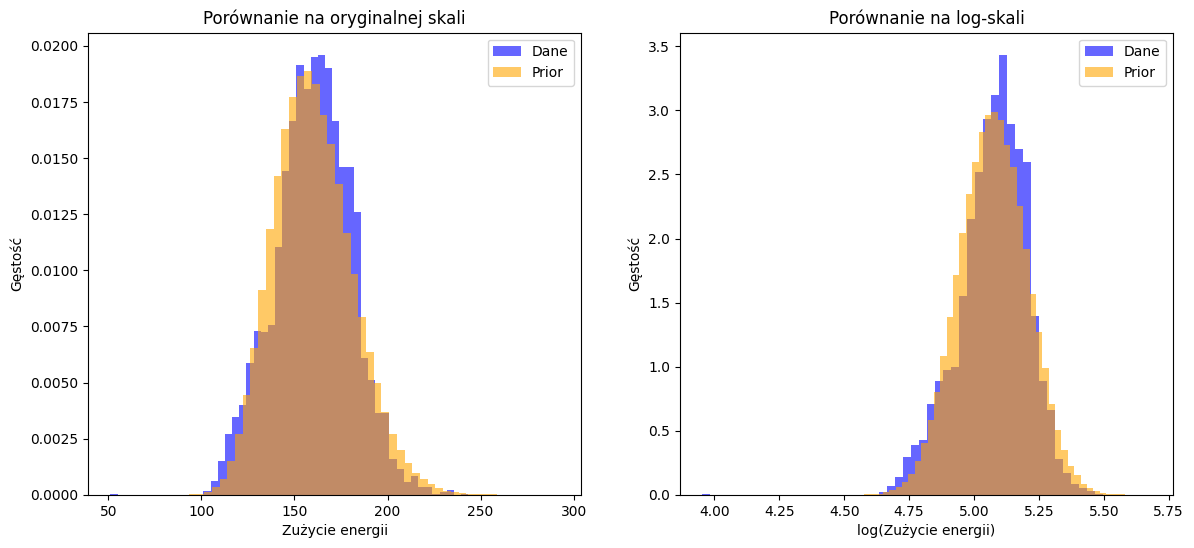

In [47]:
posterior_samples = post_1.y_sim.flatten()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title("Porównanie na oryginalnej skali")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(rat_df["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")

plt.show()


In [48]:
az.summary(post_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0       5.139   0.054    5.041    5.241      0.008    0.004      48.0   
beta1       0.094   0.071   -0.030    0.235      0.010    0.006      48.0   
beta2       0.221   0.005    0.212    0.229      0.001    0.000      72.0   
sigma       0.114   0.001    0.112    0.117      0.000    0.000      67.0   
y_sim[0]  146.915  17.354  115.385  179.866      1.284    0.948     183.0   
...           ...     ...      ...      ...        ...      ...       ...   
mu[4997]    5.129   0.002    5.125    5.133      0.000    0.000     123.0   
mu[4998]    5.139   0.002    5.135    5.144      0.000    0.000     108.0   
mu[4999]    5.139   0.002    5.135    5.144      0.000    0.000     108.0   
mu[5000]    5.139   0.002    5.135    5.144      0.000    0.000     108.0   
mu[5001]    5.145   0.002    5.141    5.150      0.000    0.000     105.0   

          ess_tail  r_hat  
beta0         45.0    NaN  
beta1         45.0    NaN  
beta2         75.0    NaN  
sigma         40.0    NaN  
y_sim[0]     112.0    NaN  
...            ...    ...  
mu[4997]      61.0    NaN  
mu[4998]      61.0    NaN  
mu[4999]      61.0    NaN  
mu[5000]      61.0    NaN  
mu[5001]      61.0    NaN  

[10008 rows x 9 columns]

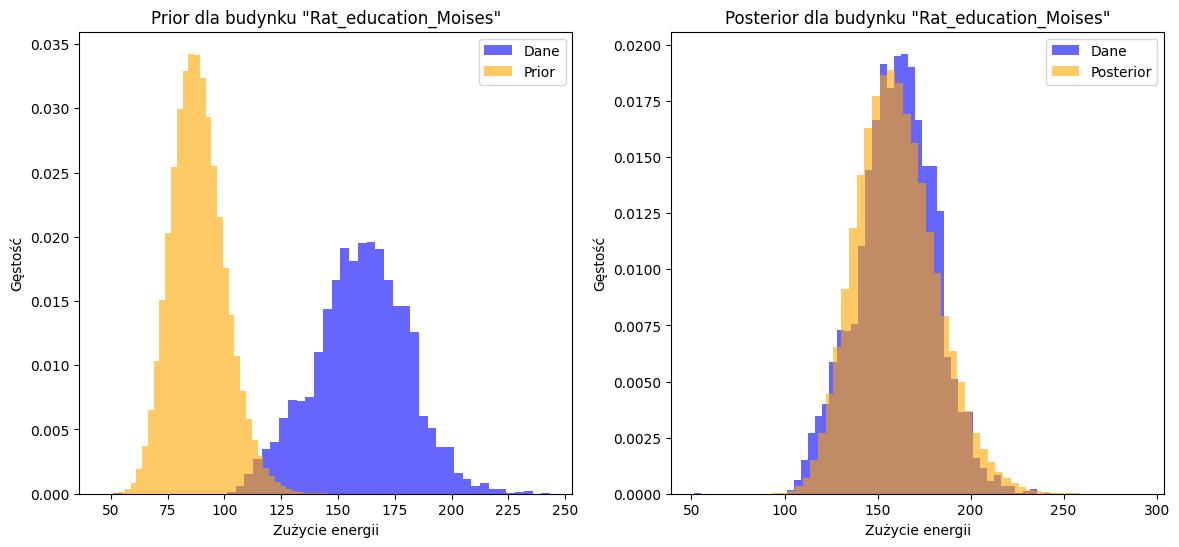

In [49]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior dla budynku "Rat_education_Moises"')

plt.subplot(1, 2, 2)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior dla budynku "Rat_education_Moises"')

plt.show()

SEZONOWOŚĆ


In [50]:
# Przykładowe dane czasowe
df_seasonal = rat_df[['airTemperature', 'sqm', "energy_consumption", 'building_id', 'timestamp']].dropna()
df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.dayofweek
df_seasonal['month'] = df_seasonal['timestamp'].dt.month

model_prior_seasonal = CmdStanModel(stan_file='not_full_data_models/prior_seasonal.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
}

# Sampling z priora
prior_1_seasonal = model_prior_seasonal.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_seasonal_df = prior_1_seasonal.draws_pd()
prior_seasonal_df.head()


14:36:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:36:21 - cmdstanpy - INFO - CmdStan done processing.


chain__  iter__  draw__  lp__  accept_stat__  y_sim[1]  y_sim[2]  y_sim[3]  \
0      1.0     1.0     1.0   0.0            0.0   76.9814   95.5312   84.1561   
1      1.0     2.0     2.0   0.0            0.0  215.6670  115.4750  125.0070   
2      1.0     3.0     3.0   0.0            0.0   81.1871  118.8130  107.5260   
3      1.0     4.0     4.0   0.0            0.0   96.3956   69.9130  133.8230   
4      1.0     5.0     5.0   0.0            0.0   83.7995  193.8830  105.2720   

   y_sim[4]  y_sim[5]  ...  y_sim[4993]  y_sim[4994]  y_sim[4995]  \
0  145.9610   76.1545  ...      85.2834      92.0864      57.8260   
1   77.8559  135.1840  ...      57.2202      63.7194     111.1030   
2  106.7090   63.7366  ...      54.5384     139.6070      62.0717   
3   73.4464  108.2710  ...      96.6138      84.7302      87.7019   
4  216.7800  138.0680  ...      64.8863      58.3383      84.8970   

   y_sim[4996]  y_sim[4997]  y_sim[4998]  y_sim[4999]  y_sim[5000]  \
0      66.1695      61.9169      60.4183      77.8732      66.0295   
1      76.2373      73.7108      64.9918     110.7440      69.9764   
2      70.3889      52.3270      67.3992     112.6930      45.1164   
3      55.3608      65.1750      91.9913      89.6174     120.1170   
4      95.5678      62.4653      89.0227      70.4123      54.7711   

   y_sim[5001]  y_sim[5002]  
0      86.0354     128.6350  
1     102.9820      84.1727  
2      78.4776      90.8112  
3      78.5094     128.5440  
4      83.2977      79.6859  

[5 rows x 5007 columns]

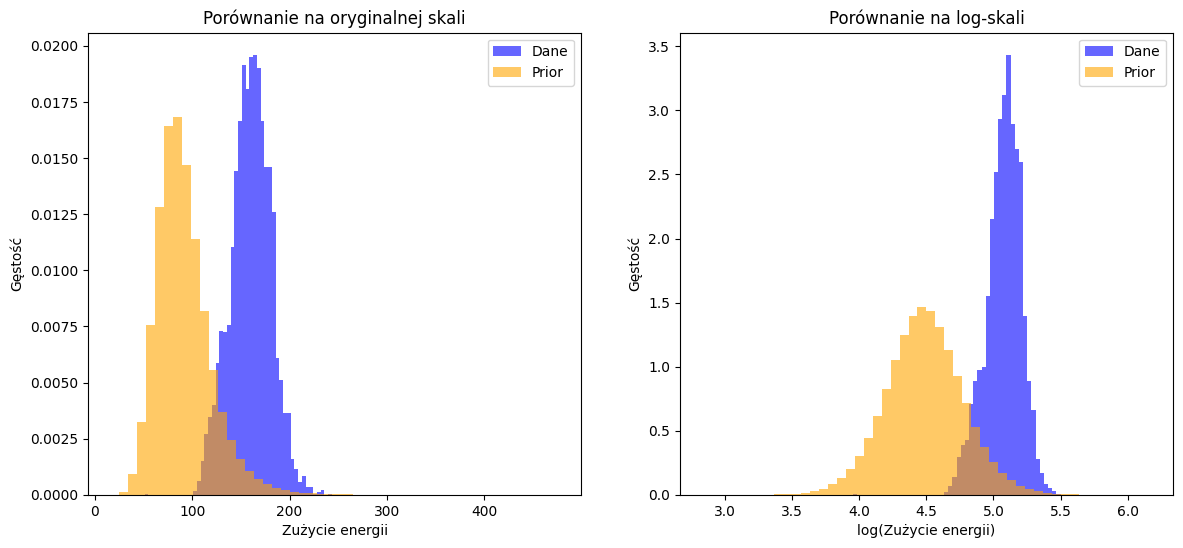

In [51]:
prior_samples = prior_1_seasonal.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title("Porównanie na oryginalnej skali")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(prior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")

plt.show()

In [52]:
model_posterior_seasonal = CmdStanModel(stan_file='not_full_data_models/posterior_seasonal.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
    'y': df_seasonal['energy_consumption'].values
}

posterior_1_seasonal = model_posterior_seasonal.sample(
    data=data, chains=1, iter_sampling=100,
)

posterior_seasonal_df = posterior_1_seasonal.draws_pd()
posterior_seasonal_df.head()

14:36:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:39:05 - cmdstanpy - INFO - CmdStan done processing.
14:39:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_seasonal.stan', line 63, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_seasonal.stan', line 63, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_seasonal.stan', line 63, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_seasonal.stan', line 63, column 4 to column 32)
Consider re-running with show_console=True if the above output is unclear!


chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0  3948.61       0.941650    0.017814          7.0   
1      1.0     2.0     2.0  3946.97       0.700277    0.017814          7.0   
2      1.0     3.0     3.0  3946.99       0.835961    0.017814          7.0   
3      1.0     4.0     4.0  3946.02       0.998636    0.017814          7.0   
4      1.0     5.0     5.0  3950.08       0.996529    0.017814          7.0   

   n_leapfrog__  divergent__  energy__  ...  log_lik[4993]  log_lik[4994]  \
0         127.0          0.0  -3943.61  ...       0.954825        1.11368   
1         127.0          0.0  -3942.43  ...       0.955874        1.10450   
2         127.0          0.0  -3942.33  ...       1.012840        1.15797   
3         127.0          0.0  -3943.39  ...       1.002160        1.13758   
4         127.0          0.0  -3944.88  ...       0.998799        1.13761   

   log_lik[4995]  log_lik[4996]  log_lik[4997]  log_lik[4998]  log_lik[4999]  \
0        1.18872        1.30472        1.31080        1.31321        1.25492   
1        1.17152        1.29943        1.31747        1.31414        1.28793   
2        1.22383        1.31537        1.30825        1.31491        1.23577   
3        1.19868        1.30390        1.30979        1.31153        1.26294   
4        1.19972        1.30678        1.31339        1.31481        1.26844   

   log_lik[5000]  log_lik[5001]  log_lik[5002]  
0        1.24777        1.24907        1.15106  
1        1.28412        1.28516        1.20683  
2        1.22822        1.23061        1.12093  
3        1.25757        1.25835        1.16402  
4        1.26406        1.26586        1.17596  

[5 rows x 10023 columns]

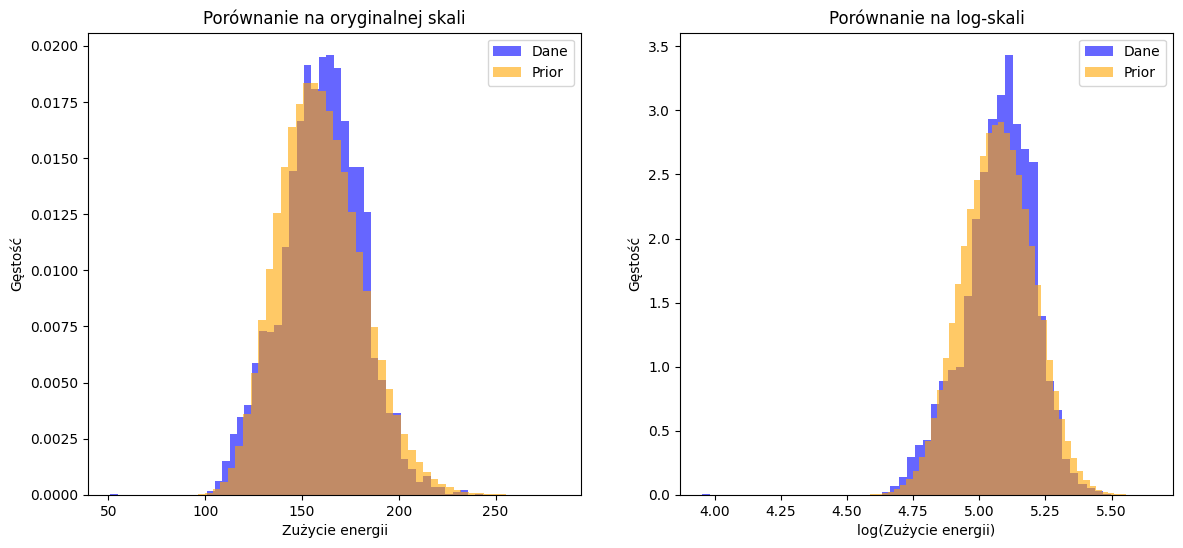

In [ ]:
posterior_samples = posterior_1_seasonal.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title("Porównanie na oryginalnej skali")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")

plt.show()

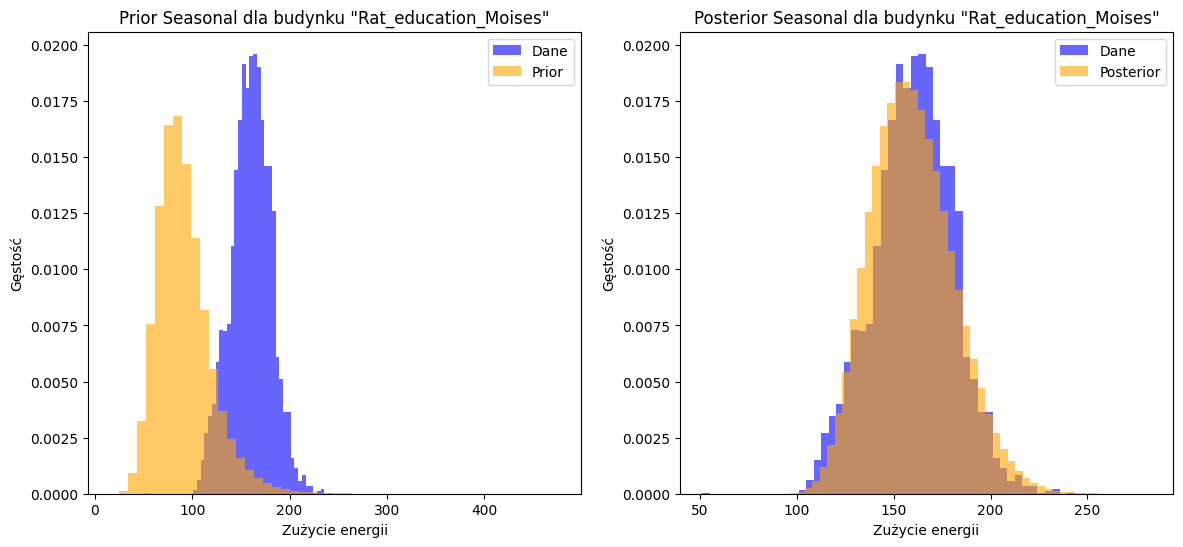

In [74]:
posterior_samples = posterior_1_seasonal.y_sim.flatten()
prior_samples = prior_1_seasonal.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior Seasonal dla budynku "Rat_education_Moises"')

plt.subplot(1, 2, 2)
plt.hist(rat_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior Seasonal dla budynku "Rat_education_Moises"')

plt.show()

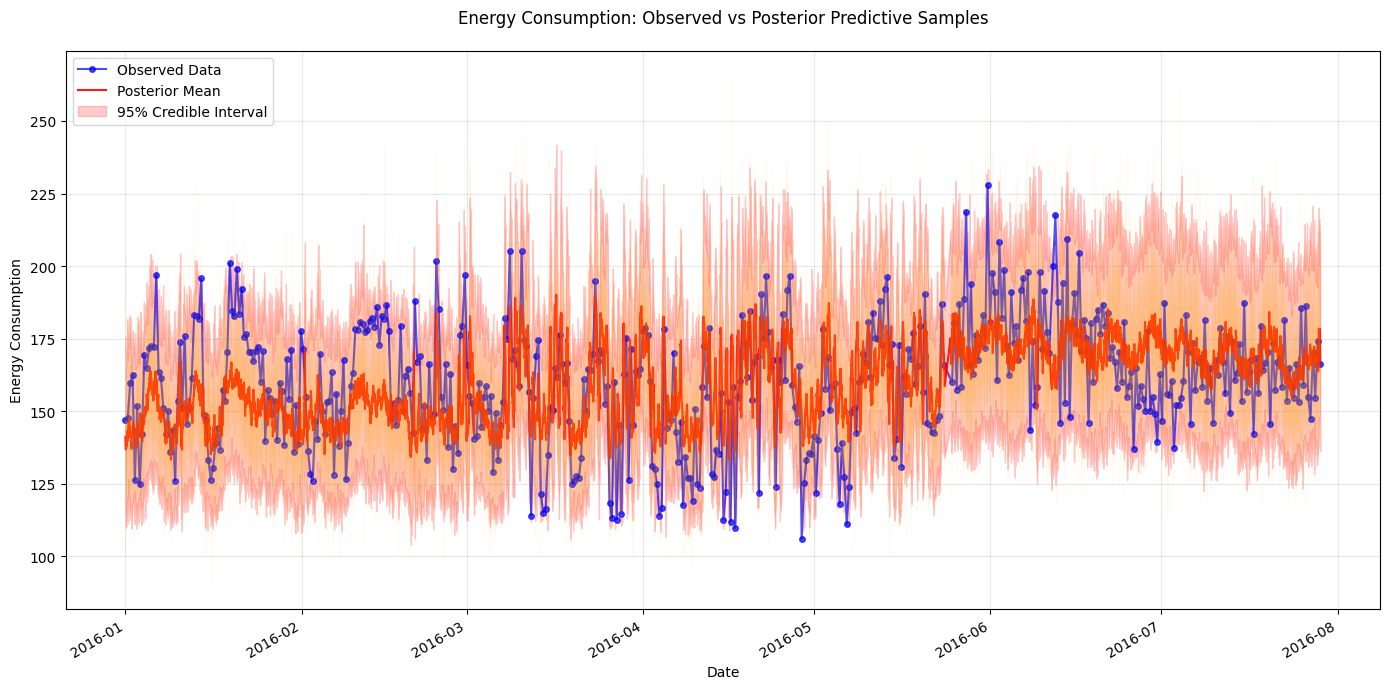

In [76]:
# Prepare data
dates = rat_df['timestamp'].values # Assuming your df_seasonal has timestamps
observed = rat_df["energy_consumption"].values
simulated = posterior_1_seasonal.y_sim  # Shape: (samples, observations)

# Calculate statistics
mean_sim = np.mean(simulated, axis=0)
upper_95 = np.percentile(simulated, 97.5, axis=0)
lower_95 = np.percentile(simulated, 2.5, axis=0)

# Create time series plot
plt.figure(figsize=(14, 7))

# Plot observed data (every 10th point for clarity)
plt.plot(dates[::10], observed[::10], 
         color='blue', alpha=0.7, label='Observed Data', 
         linewidth=1.5, marker='o', markersize=4)

# Plot posterior predictive
plt.plot(dates, mean_sim, color='red', 
         alpha=0.9, label='Posterior Mean')
plt.fill_between(dates, lower_95, upper_95, 
                color='red', alpha=0.2, 
                label='95% Credible Interval')

# Plot some individual posterior samples
for i in range(0, 100, 10):  # Plot every 200th sample
    plt.plot(dates, simulated[i], 
             color='orange', alpha=0.05, 
             linewidth=0.5)

# Formatting
plt.title('Energy Consumption: Observed vs Posterior Predictive Samples', pad=20)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend(loc='upper left')

# Improve x-axis for dates
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Porównanie modeli

In [71]:
import arviz as az

posterior_idata = az.from_cmdstanpy(
    posterior=post_1,
    posterior_predictive="y_sim"
)

loo_result = az.loo(posterior_idata)
waic_result = az.waic(posterior_idata)

print("LOO:", loo_result)
print("WAIC:", waic_result)



LOO: Computed from 100 posterior samples and 5002 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  3743.02    69.62
p_loo        4.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     4981   99.6%
   (0.50, 1]   (bad)        20    0.4%
   (1, Inf)   (very bad)    1    0.0%

WAIC: Computed from 100 posterior samples and 5002 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  3743.20    69.53
p_waic        4.21        -

There has been a warning during the calculation. Please check the results.


In [72]:
posterior_seasonal_idata = az.from_cmdstanpy(
    posterior=posterior_1_seasonal,
    posterior_predictive="y_sim"
)
loo_result = az.loo(posterior_seasonal_idata)
waic_result = az.waic(posterior_seasonal_idata)

print("LOO:", loo_result)
print("WAIC:", waic_result)

LOO: Computed from 100 posterior samples and 5002 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  3904.62    77.03
p_loo        9.06        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     4963   99.2%
   (0.50, 1]   (bad)        39    0.8%
   (1, Inf)   (very bad)    0    0.0%

WAIC: Computed from 100 posterior samples and 5002 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  3904.67    77.07
p_waic        9.01        -

There has been a warning during the calculation. Please check the results.


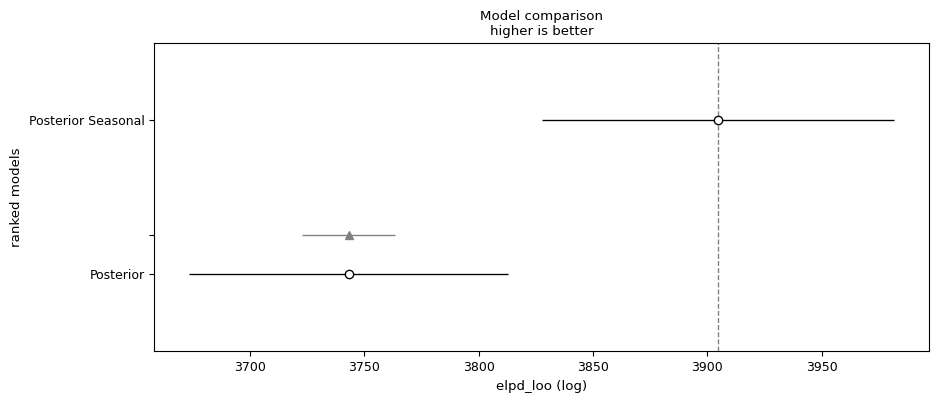

In [73]:
compare_dict = {
        "Posterior Seasonal": posterior_1_seasonal,
        "Posterior": post_1,
    }
compare_df =az.compare(compare_dict)

# Narysuj wykres porównawczy
az.plot_compare(compare_df, figsize=(10, 4), plot_ic_diff=True, insample_dev=False)
plt.show()

### Generacja próbek

14:39:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:39:14 - cmdstanpy - INFO - CmdStan done processing.
14:39:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
Consider re-running with show_console=True if the above output is unclear!




Wynik prognozy zużycia energii:
- Aktualna temperatura: 4.4°C
- Powierzchnia: 22117 m²
- Przewidywane zużycie energii: 183.8 kWh
- 95% przedział niepewności: (155.6, 219.4) kWh


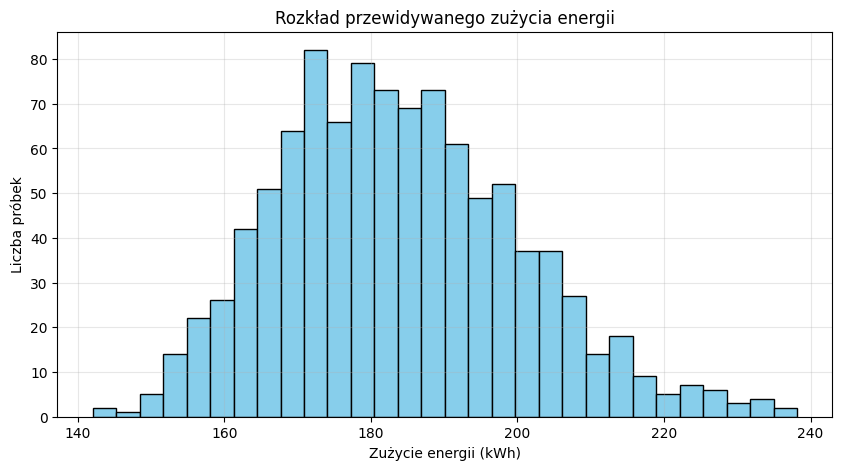

In [58]:
# 1. Wczytanie danych historycznych
df_subset = rat_df[['airTemperature', 'sqm', 'energy_consumption']].dropna().copy()

N = 100
df_subset = df_subset.iloc[:N]

# 2. Przygotowanie danych dla modelu
data = {
    'N': len(df_subset),
    'temp': df_subset['airTemperature'].values.astype(float),
    'sqm': df_subset['sqm'].values.astype(float),
    'y': df_subset['energy_consumption'].values.astype(float)
}

# 3. Wczytanie modelu
model = CmdStanModel(stan_file='not_full_data_models/posterior.stan')

# 4. Pobranie aktualnych danych (tutaj przykładowe wartości - zastąp rzeczywistymi)
current_temp = 4.4
current_sqm = 22117

# 5. Przygotowanie danych predykcyjnych
pred_data = data.copy()
pred_data['temp'] = np.append(data['temp'][-99:], current_temp)
pred_data['sqm'] = np.append(data['sqm'][-99:], current_sqm)
pred_data['N'] = len(pred_data['temp'])

# 6. Generowanie prognozy
fit = model.sample(data=pred_data, chains=1, iter_sampling=1000)
y_sim = fit.stan_variable('y_sim')[:, -1]

# 7. Analiza wyników
print("\nWynik prognozy zużycia energii:")
print(f"- Aktualna temperatura: {current_temp}°C")
print(f"- Powierzchnia: {current_sqm} m²")
print(f"- Przewidywane zużycie energii: {np.mean(y_sim):.1f} kWh")
print(f"- 95% przedział niepewności: ({np.percentile(y_sim, 2.5):.1f}, {np.percentile(y_sim, 97.5):.1f}) kWh")

# 8. Wizualizacja rozkładu prognozy (opcjonalnie)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(y_sim, bins=30, color='skyblue', edgecolor='black')
plt.title('Rozkład przewidywanego zużycia energii')
plt.xlabel('Zużycie energii (kWh)')
plt.ylabel('Liczba próbek')
plt.grid(True, alpha=0.3)
plt.show()

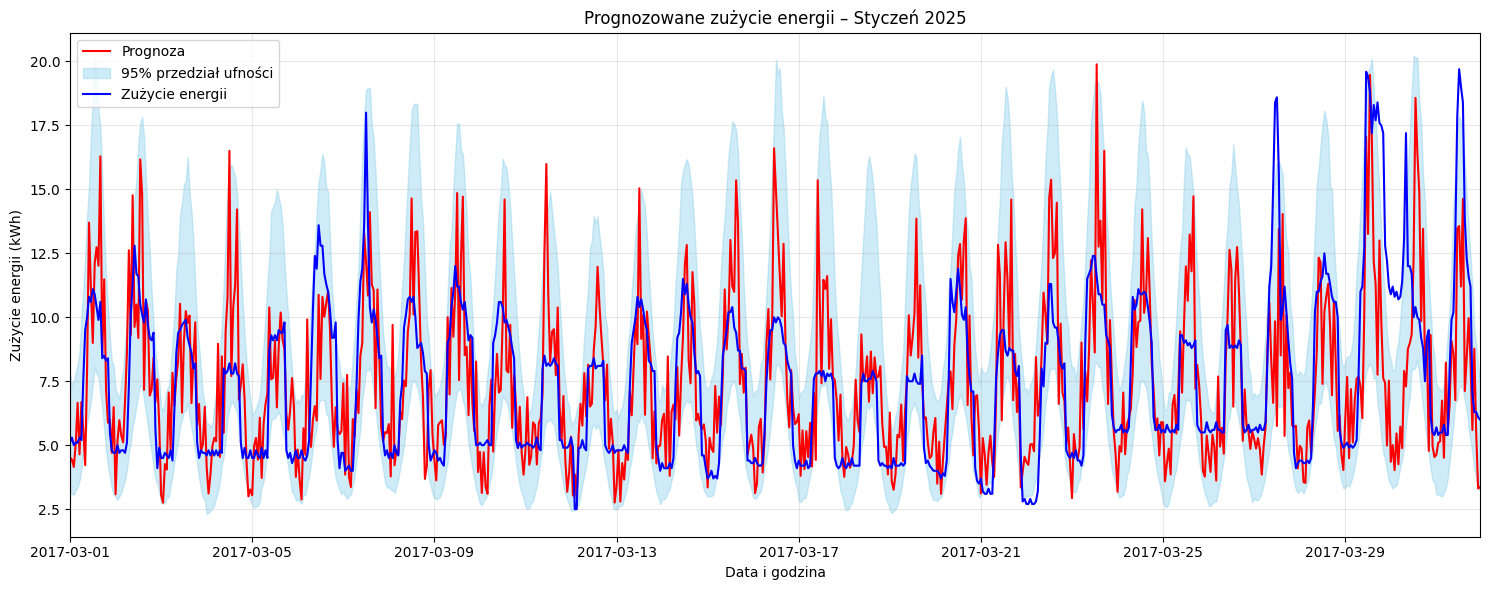

In [ ]:
# 9. Tworzenie wykresu liniowego
plt.figure(figsize=(15, 6))
plt.plot(df_seasonal['timestamp'], y_sim[0], label="Prognoza", color="red")
plt.fill_between(df_seasonal['timestamp'], y_lower, y_upper, color="skyblue", alpha=0.4, label="95% przedział ufności")
plt.plot(df_seasonal['timestamp'], df_seasonal['energy_consumption'], label="Zużycie energii", color="blue")
plt.title("Prognozowane zużycie energii – Styczeń 2025")
plt.xlabel("Data i godzina")
plt.ylabel("Zużycie energii (kWh)")
plt.xlim(df_seasonal['timestamp'].min(), df_seasonal['timestamp'].max())
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Wszystkie dane test

In [21]:
df_all_val = df_final.dropna(subset=['energy_consumption',"airTemperature", "sqm","timestamp", "building_id", "lat","lng","industry", "numberoffloors", "occupants", "yearbuilt"])
df_all_val.head()

timestamp          building_id  energy_consumption site_id  \
13724760 2016-01-01 01:00:00  Lamb_assembly_Cesar                 8.7    Lamb   
13724761 2016-01-01 02:00:00  Lamb_assembly_Cesar                 9.0    Lamb   
13724762 2016-01-01 03:00:00  Lamb_assembly_Cesar                 9.5    Lamb   
13724763 2016-01-01 04:00:00  Lamb_assembly_Cesar                 8.9    Lamb   
13724764 2016-01-01 05:00:00  Lamb_assembly_Cesar                 8.6    Lamb   

             sqm        lat       lng       timezone    industry  yearbuilt  \
13724760  1422.0  51.497838 -3.186246  Europe/London  Government     1976.0   
13724761  1422.0  51.497838 -3.186246  Europe/London  Government     1976.0   
13724762  1422.0  51.497838 -3.186246  Europe/London  Government     1976.0   
13724763  1422.0  51.497838 -3.186246  Europe/London  Government     1976.0   
13724764  1422.0  51.497838 -3.186246  Europe/London  Government     1976.0   

          numberoffloors  occupants  airTemperature  
13724760             2.0        0.0             5.0  
13724761             2.0        0.0             3.0  
13724762             2.0        0.0             4.0  
13724763             2.0        0.0             4.0  
13724764             2.0        0.0             5.0

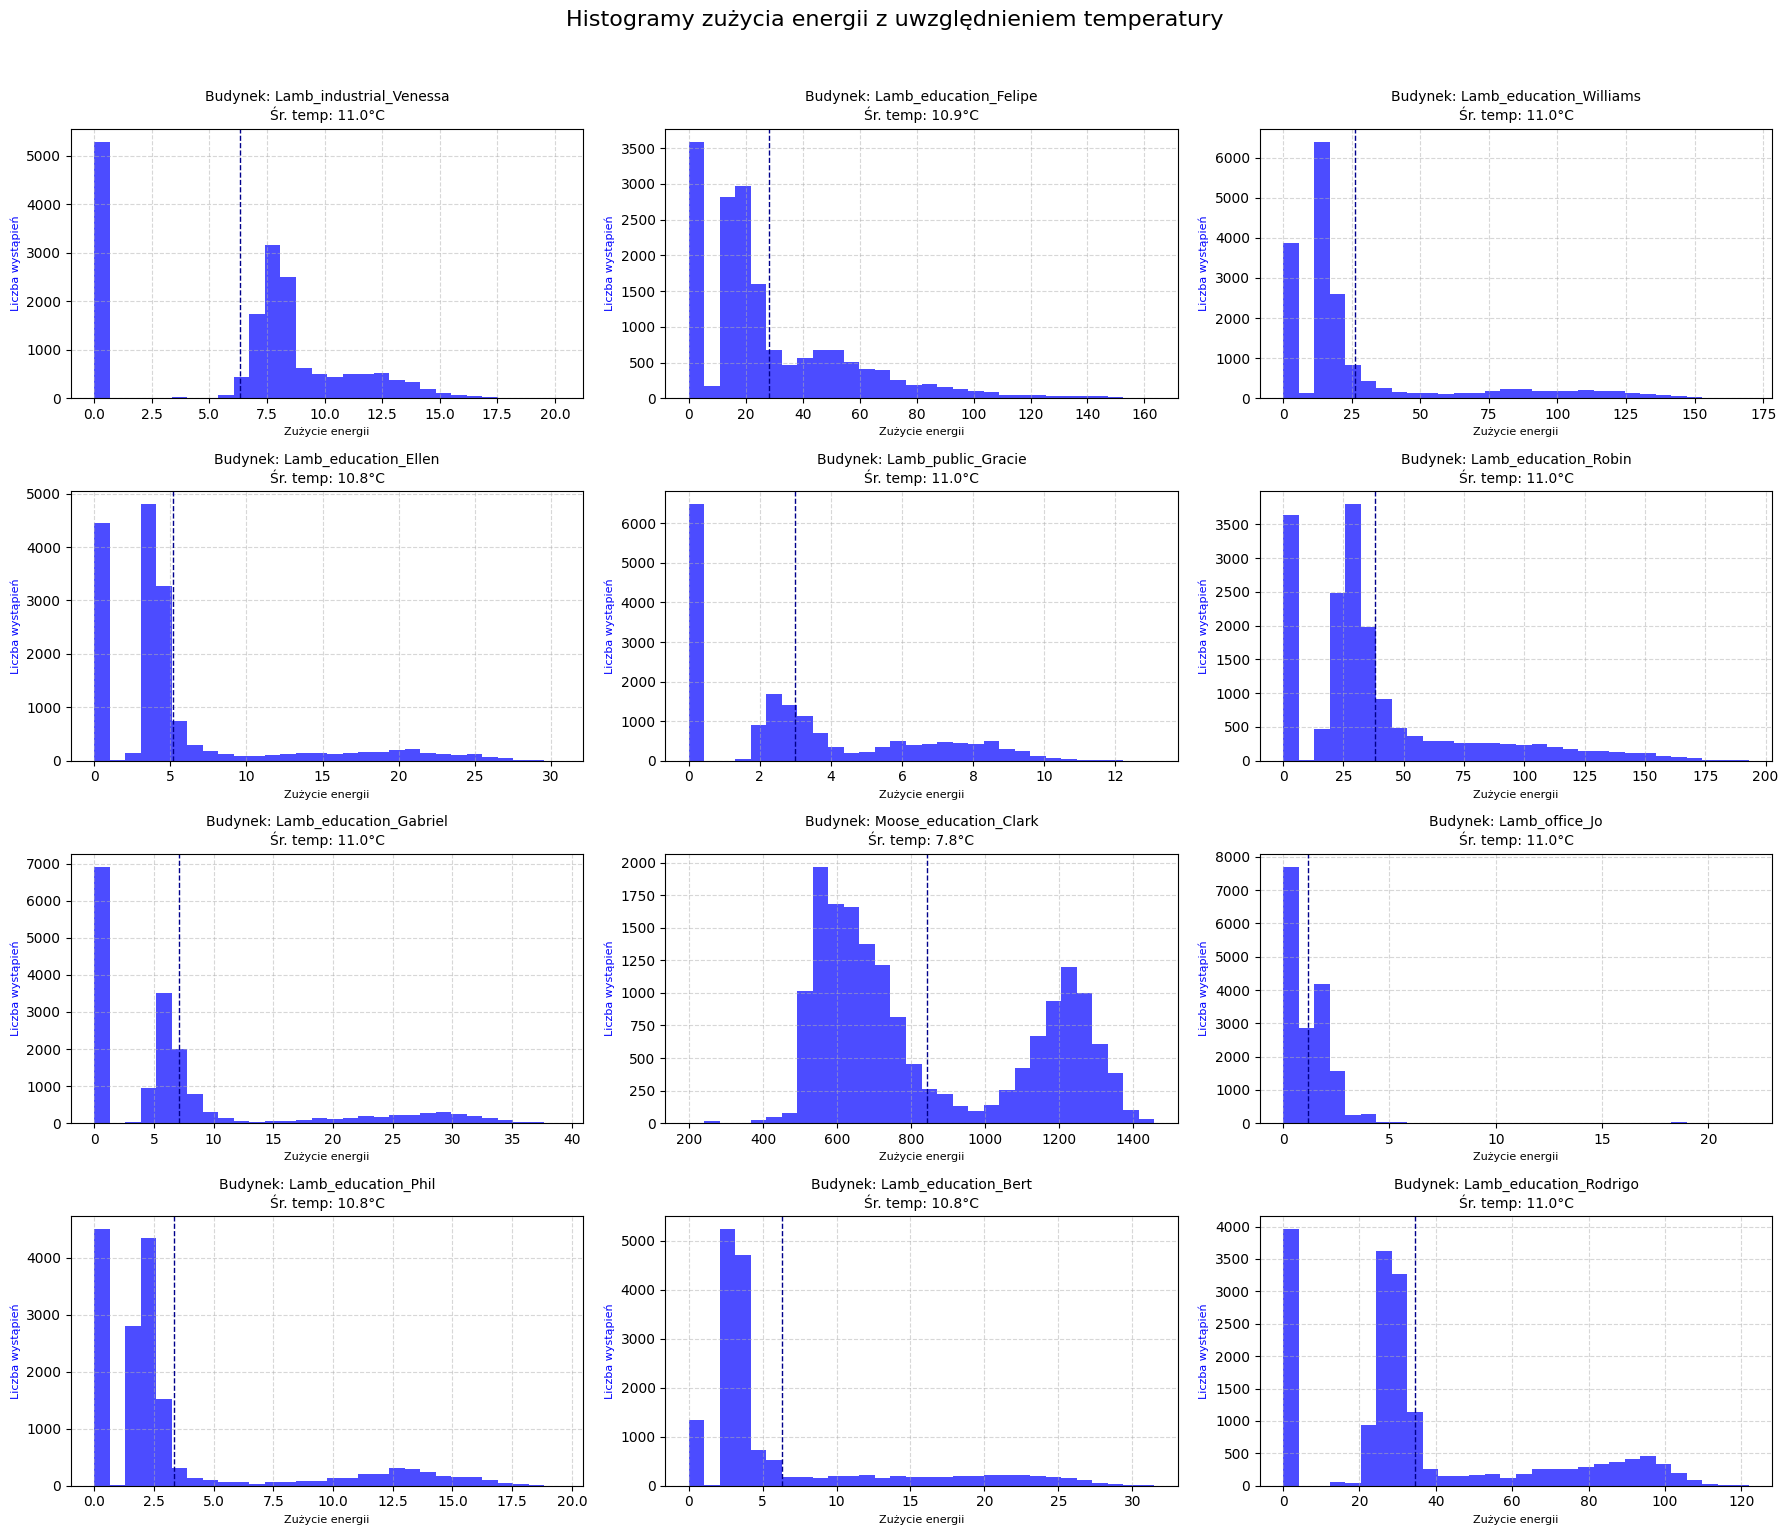

In [22]:

# 2. Wybór 12 losowych budynków
unique_buildings = df_all_val['building_id'].unique()
random_buildings = np.random.choice(unique_buildings, size=12, replace=False)

# 3. Przygotowanie wykresów
fig, axes = plt.subplots(4, 3, figsize=(18, 15))
fig.suptitle('Histogramy zużycia energii z uwzględnieniem temperatury', fontsize=16, y=1.02)

for i, building_id in enumerate(random_buildings):
    # Dane dla wybranego budynku
    building_data = df_all_val[df_all_val['building_id'] == building_id]
    
    # Pozycja subplotu
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Histogram zużycia energii
    ax.hist(building_data['energy_consumption'], bins=30, color='blue', alpha=0.7)

    # Formatowanie
    ax.set_title(f'Budynek: {building_id}\nŚr. temp: {building_data["airTemperature"].mean():.1f}°C', fontsize=10)
    ax.set_xlabel('Zużycie energii', fontsize=8)
    ax.set_ylabel('Liczba wystąpień', fontsize=8, color='blue')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Linie średnich
    ax.axvline(building_data['energy_consumption'].mean(), color='darkblue', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# 

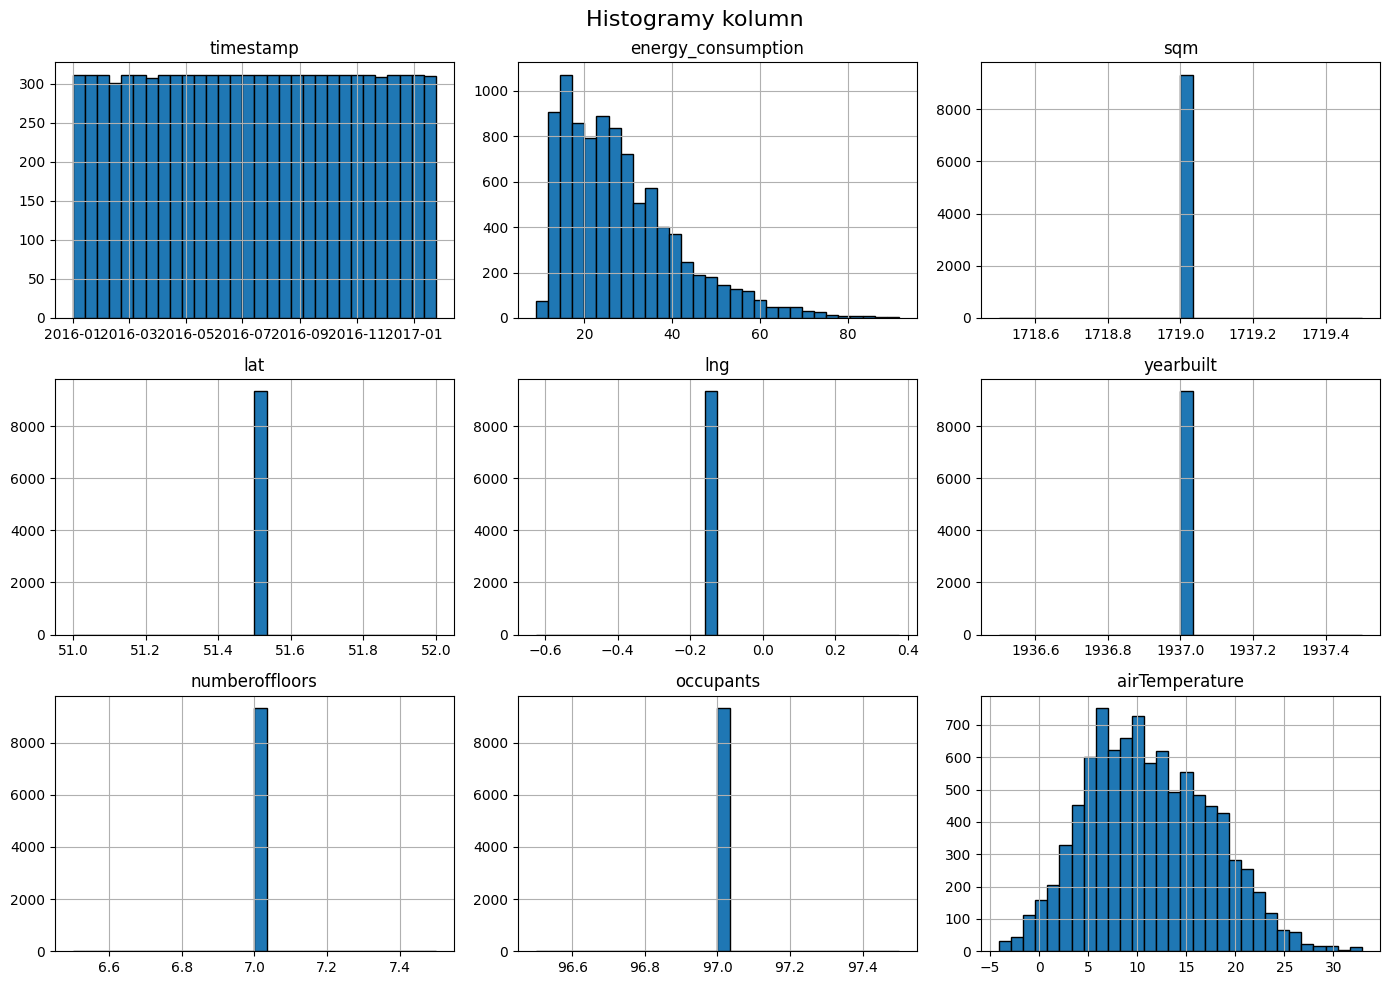

In [23]:
df_shrew = df_all_val[df_all_val['building_id'] == "Shrew_office_Kenneth"]

df_shrew.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)

plt.suptitle('Histogramy kolumn', fontsize=16)
plt.tight_layout()
plt.show()

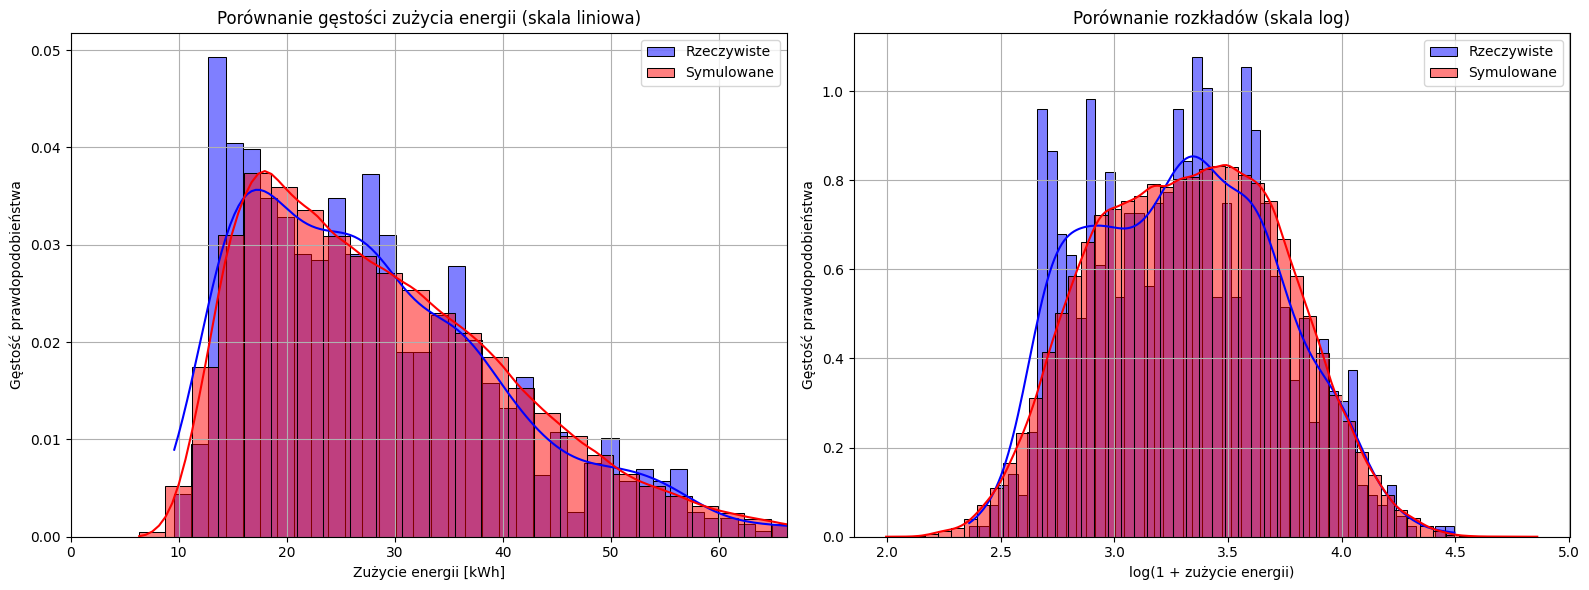

In [24]:

# Ustawienia stylu i rozmiaru wykresów
plt.rcParams['figure.figsize'] = (16, 6)

def calculate_density_comparison(real_data, simulated_data, max_points=10000):
    """
    Funkcja obliczająca i porównująca gęstości rozkładów
    """
    combined_data = np.concatenate([real_data.reshape(-1), simulated_data.reshape(-1)])
    min_val = np.min(combined_data)
    max_val = np.percentile(combined_data, 99.9)
    
    grid = np.linspace(min_val, max_val, 500)
    kde_real = gaussian_kde(real_data)(grid)
    kde_sim = gaussian_kde(simulated_data)(grid)
    
    return grid, kde_real, kde_sim

def simulate_from_prior(sqm, temp, num_samples=1000):
    log_sqm = np.log1p(sqm)
    log_sqm_scaled = (log_sqm - np.mean(log_sqm)) / np.std(log_sqm)
    temp_scaled = (temp - np.mean(temp)) / np.std(temp)
    
    beta0 = np.random.normal(2.5, 0.1, num_samples)  # Średni poziom zużycia
    beta1 = np.random.normal(1, 0.1, num_samples)  # Wpływ powierzchni
    beta2 = np.random.normal(-1.2, 0.5, num_samples) # Wpływ temperatury
    sigma = np.random.lognormal(-3, 0.5, num_samples) # Kontrola rozrzutu
    
    mu = beta0[:, None] + \
         beta1[:, None] * np.tanh(log_sqm_scaled) + \
         beta2[:, None] * temp_scaled * np.exp(-temp_scaled**2)  # Lokalne ekstremum
    
    simulated = np.exp(np.random.normal(mu, sigma[:, None]))
    simulated = np.minimum(simulated, 2000) 
    
    return simulated.flatten()

sample_size = 1000
clean_data = df_shrew[['energy_consumption',"airTemperature", "sqm","timestamp", "building_id", "lat","lng", "numberoffloors", "occupants", "yearbuilt"]]

if len(clean_data) > sample_size:
    real_sample = clean_data.sample(n=sample_size, random_state=42)
else:
    real_sample = clean_data.copy()

real_energy = real_sample["energy_consumption"].values
sqm = real_sample["sqm"].values
temp = real_sample["airTemperature"].values

simulated_data = simulate_from_prior(sqm, temp)

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(real_energy, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax1, stat='density', kde=True)
sns.histplot(simulated_data, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax1, stat='density', kde=True)
ax1.set_title('Porównanie gęstości zużycia energii (skala liniowa)')
ax1.set_xlabel('Zużycie energii [kWh]')
ax1.set_ylabel('Gęstość prawdopodobieństwa')
ax1.legend()
ax1.grid(True)

combined = np.concatenate([real_energy, simulated_data])
ax1.set_xlim(0, np.percentile(combined, 99))

log_real = np.log1p(real_energy)
log_sim = np.log1p(simulated_data)

sns.histplot(log_real, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax2, stat='density', kde=True)
sns.histplot(log_sim, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax2, stat='density', kde=True)
ax2.set_title('Porównanie rozkładów (skala log)')
ax2.set_xlabel('log(1 + zużycie energii)')
ax2.set_ylabel('Gęstość prawdopodobieństwa')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [25]:
df_seasonal = df_shrew[['energy_consumption',"airTemperature", "sqm","timestamp", "building_id", "lat","lng", "numberoffloors", "occupants", "yearbuilt"]]
df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.day_of_week
df_seasonal['month'] = df_seasonal['timestamp'].dt.month

model_posterior = CmdStanModel(stan_file='full_data_models/posterior.stan')
model_posterior_seasonal = CmdStanModel(stan_file='full_data_models/posterior_seasonal.stan')
model_posterior_all = CmdStanModel(stan_file='full_data_models/posterior_all.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'y': df_seasonal['energy_consumption'].values
}

data_seasonal = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
    'y': df_seasonal['energy_consumption'].values
}

data_all = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'occupants': df_seasonal['occupants'].values,
    'numberoffloors': df_seasonal['numberoffloors'].values,
    'yearbuilt': df_seasonal['yearbuilt'].values,
    'lat': df_seasonal['lat'].values,
    'lng': df_seasonal['lng'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
    'y': df_seasonal['energy_consumption'].values
}

posterior = model_posterior.sample(
    data=data, chains=1, iter_sampling=100,
)

posterior_seasonal = model_posterior_seasonal.sample(
    data=data_seasonal, chains=1, iter_sampling=100,
)

posterior_all = model_posterior_all.sample(
    data=data_all, chains=1, iter_sampling=100,
)


15:51:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:52:43 - cmdstanpy - INFO - CmdStan done processing.
15:52:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
Consider re-running with show_console=True if the above output is uncl

15:52:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

16:13:19 - cmdstanpy - INFO - CmdStan done processing.
16:13:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_seasonal.stan', line 68, column 4 to column 32)
	Exception: logn

16:13:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 35 iterations at max treedepth (35.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
16:13:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:03:32 - cmdstanpy - INFO - CmdStan done processing.
17:03:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all.stan', line 91, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is

17:03:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 37 iterations at max treedepth (37.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


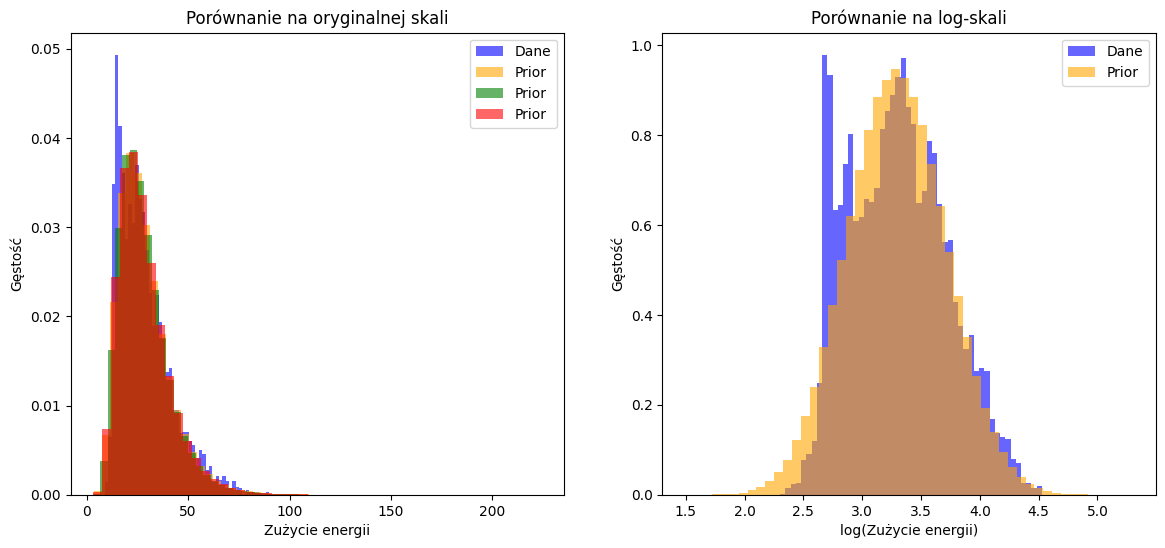

In [67]:
posterior_samples = posterior.y_sim.flatten()
posterior_seasonal_samples = posterior_seasonal.y_sim.flatten()
posterior_all_samples = posterior_all.y_sim.flatten()



plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_seasonal["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.hist(posterior_seasonal_samples, bins=50, alpha=0.6, label="Prior", color='green', density=True)
plt.hist(posterior_all_samples, bins=50, alpha=0.6, label="Prior", color='red', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title("Porównanie na oryginalnej skali")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_seasonal["energy_consumption"]), bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(np.log1p(posterior_samples), bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("log(Zużycie energii)")
plt.ylabel("Gęstość")
plt.title("Porównanie na log-skali")

plt.show()

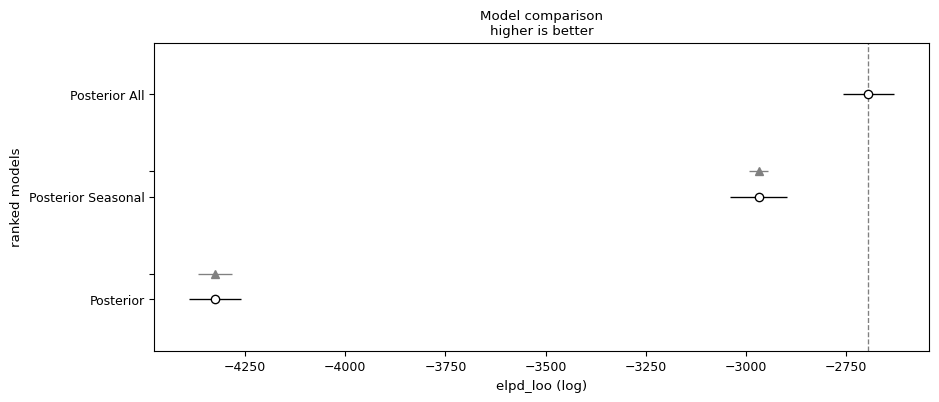

In [68]:
compare_dict = {
        "Posterior All": posterior_all,
        "Posterior Seasonal": posterior_seasonal,
        "Posterior": posterior,
    }
compare_df =az.compare(compare_dict)

# Narysuj wykres porównawczy
az.plot_compare(compare_df, figsize=(10, 4), plot_ic_diff=True, insample_dev=False)
plt.show()

In [28]:
psm = az.from_cmdstanpy(
    posterior=posterior,
    posterior_predictive="y_sim"
)
loo_psm = az.loo(psm)
waic_psm = az.waic(psm)

print("LOO:", loo_psm)
print("WAIC:", waic_psm)

LOO: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4325.81    64.20
p_loo        2.87        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     9298   99.6%
   (0.50, 1]   (bad)        38    0.4%
   (1, Inf)   (very bad)    0    0.0%

WAIC: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4325.75    64.20
p_waic        2.82        -


In [310]:
psm = az.from_cmdstanpy(
    posterior=posterior_seasonal,
    posterior_predictive="y_sim"
)
loo_psm = az.loo(psm)
waic_psm = az.waic(psm)

print("LOO:", loo_psm)
print("WAIC:", waic_psm)

LOO: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2968.14    70.70
p_loo        6.11        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     9258   99.2%
   (0.50, 1]   (bad)        78    0.8%
   (1, Inf)   (very bad)    0    0.0%

WAIC: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2968.05    70.70
p_waic        6.01        -


In [27]:
psm = az.from_cmdstanpy(
    posterior=posterior_all,
    posterior_predictive="y_sim"
)
loo_psm = az.loo(psm)
waic_ps = az.waic(psm)

print("LOO:", loo_psm)
print("WAIC:", waic_ps)

LOO: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2690.87    63.97
p_loo        6.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     9221   98.8%
   (0.50, 1]   (bad)       115    1.2%
   (1, Inf)   (very bad)    0    0.0%

WAIC: Computed from 100 posterior samples and 9336 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2690.76    63.96
p_waic        6.57        -


In [312]:
len(df_shrew)

9336

### Shrew - I model

In [29]:
# Zakładamy, że mamy kolumnę np. "energy"
# df_subset = df_final[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()
df_subset = df_shrew[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()

# Creating models
N = len(df_subset)
df_subset = df_subset.iloc[:N]

model_prior = CmdStanModel(stan_file='full_data_models/prior.stan')

temp = df_subset['airTemperature']
sqm	= df_subset['sqm']

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm}

# Sampling z priora
prior_1 = model_prior.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_df = prior_1.draws_pd()
prior_df.head()

data = {'N': N, 'temp': df_subset['airTemperature'], 'sqm': df_subset['sqm'], 'y': df_subset['energy_consumption']}
model_posterior = CmdStanModel(stan_file='full_data_models/posterior.stan')
post_1 = model_posterior.sample(data=data, chains=1, iter_sampling=100)

# Odczyt wyników
posterior_df = post_1.draws_pd()
posterior_df.head()


17:10:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:10:52 - cmdstanpy - INFO - CmdStan done processing.


17:10:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:12:20 - cmdstanpy - INFO - CmdStan done processing.
17:12:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positi

chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -4407.37       0.979918    0.043146          7.0   
1      1.0     2.0     2.0 -4404.42       0.986948    0.043146          6.0   
2      1.0     3.0     3.0 -4404.10       0.916451    0.043146          6.0   
3      1.0     4.0     4.0 -4405.09       0.999736    0.043146          5.0   
4      1.0     5.0     5.0 -4404.16       0.999965    0.043146          6.0   

   n_leapfrog__  divergent__  energy__  ...  log_lik[9327]  log_lik[9328]  \
0         127.0          0.0   4411.41  ...      -0.992322       -1.28794   
1          63.0          0.0   4407.82  ...      -1.005810       -1.29390   
2          63.0          0.0   4405.81  ...      -1.021800       -1.30970   
3          31.0          0.0   4405.11  ...      -1.032340       -1.31933   
4          63.0          0.0   4405.99  ...      -1.019050       -1.30958   

   log_lik[9329]  log_lik[9330]  log_lik[9331]  log_lik[9332]  log_lik[9333]  \
0      -0.971703      -0.620097      -0.399471      -0.115371      -0.155414   
1      -0.986991      -0.640835      -0.418172      -0.127294      -0.167027   
2      -1.003540      -0.655963      -0.429891      -0.132344      -0.172516   
3      -1.014580      -0.666814      -0.438636      -0.136637      -0.177015   
4      -1.000370      -0.650391      -0.423933      -0.126924      -0.167240   

   log_lik[9334]  log_lik[9335]  log_lik[9336]  
0      -0.112204      -0.146252      -0.207565  
1      -0.122667      -0.154574      -0.213141  
2      -0.127020      -0.158483      -0.216716  
3      -0.130756      -0.161734      -0.219491  
4      -0.121884      -0.153832      -0.212732  

[5 rows x 28022 columns]

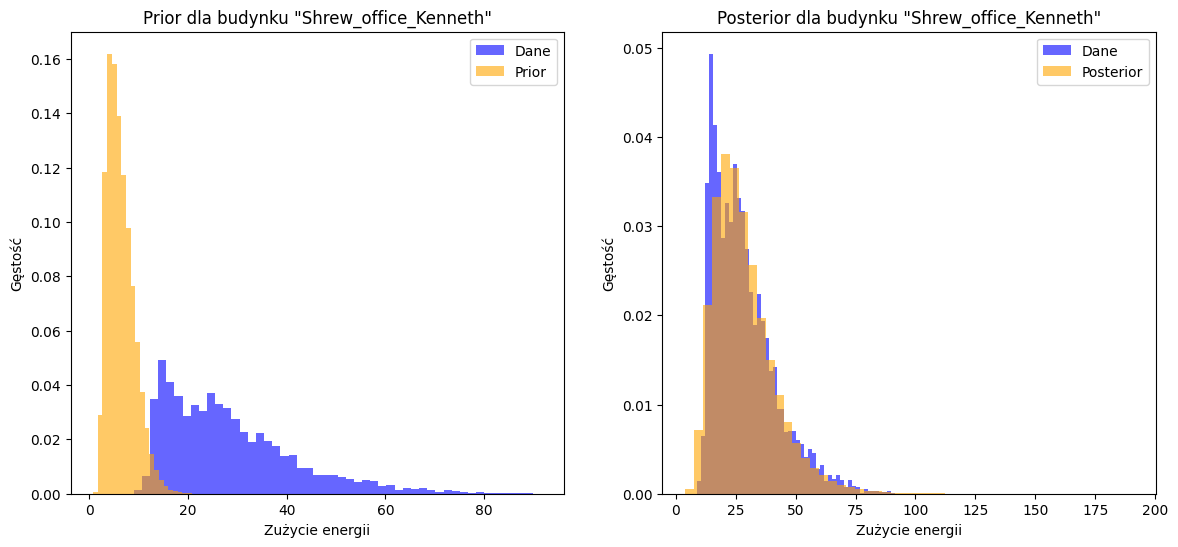

In [ ]:
prior_samples = prior_1.y_sim.flatten()
posterior_samples = post_1.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior dla budynku "Shrew_office_Kenneth"')

plt.subplot(1, 2, 2)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior dla budynku "Shrew_office_Kenneth"')

plt.show()

In [ ]:
# Przykładowe dane czasowe
df_seasonal = df_shrew[['airTemperature', 'sqm', "energy_consumption", 'building_id', 'timestamp']].dropna()
df_seasonal['hour'] = df_shrew['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_shrew['timestamp'].dt.dayofweek
df_seasonal['month'] = df_shrew['timestamp'].dt.month

model2_prior_seasonal = CmdStanModel(stan_file='full_data_models/prior_seasonal.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
}


# Sampling z priora
prior_2_seasonal = model2_prior_seasonal.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)



22:45:02 - cmdstanpy - INFO - compiling stan file C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\full_data_models\prior_seasonal.stan to exe file C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\full_data_models\prior_seasonal.exe
22:45:25 - cmdstanpy - INFO - compiled model executable: C:\Users\Julia\Desktop\Praca_magisterska\SmartIO\BAYESIAN\full_data_models\prior_seasonal.exe
22:45:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

22:45:47 - cmdstanpy - INFO - CmdStan done processing.


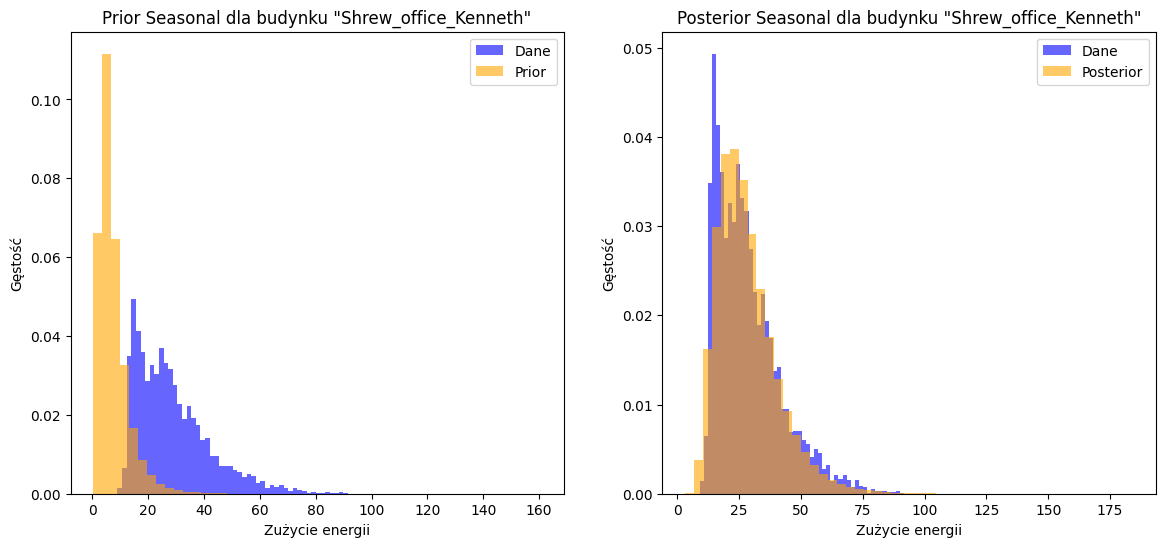

In [84]:
prior_samples = prior_2_seasonal.y_sim.flatten()
posterior_samples = posterior_seasonal.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior Seasonal dla budynku "Shrew_office_Kenneth"')

plt.subplot(1, 2, 2)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior Seasonal dla budynku "Shrew_office_Kenneth"')

plt.show()

In [81]:
# Przykładowe dane czasowe
df_seasonal = df_shrew[['airTemperature', 'sqm', "energy_consumption", 'building_id', 'timestamp', 'occupants',
                        'lat', 'lng', 'numberoffloors','yearbuilt']].dropna()
df_seasonal['hour'] = df_shrew['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_shrew['timestamp'].dt.dayofweek
df_seasonal['month'] = df_shrew['timestamp'].dt.month

model2_prior_all = CmdStanModel(stan_file='full_data_models/prior_all.stan')

data = {
    'N': len(df_seasonal),
    'sqm': df_seasonal['sqm'].values,
    'temp': df_seasonal['airTemperature'].values,
    'occupants': df_seasonal['occupants'].values,
    'numberoffloors': df_seasonal['numberoffloors'].values,
    'yearbuilt': df_seasonal['yearbuilt'].values,
    'lat': df_seasonal['lat'].values,
    'lng': df_seasonal['lng'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
}


# Sampling z priora
prior_2_all = model2_prior_seasonal.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)



22:53:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

22:53:17 - cmdstanpy - INFO - CmdStan done processing.


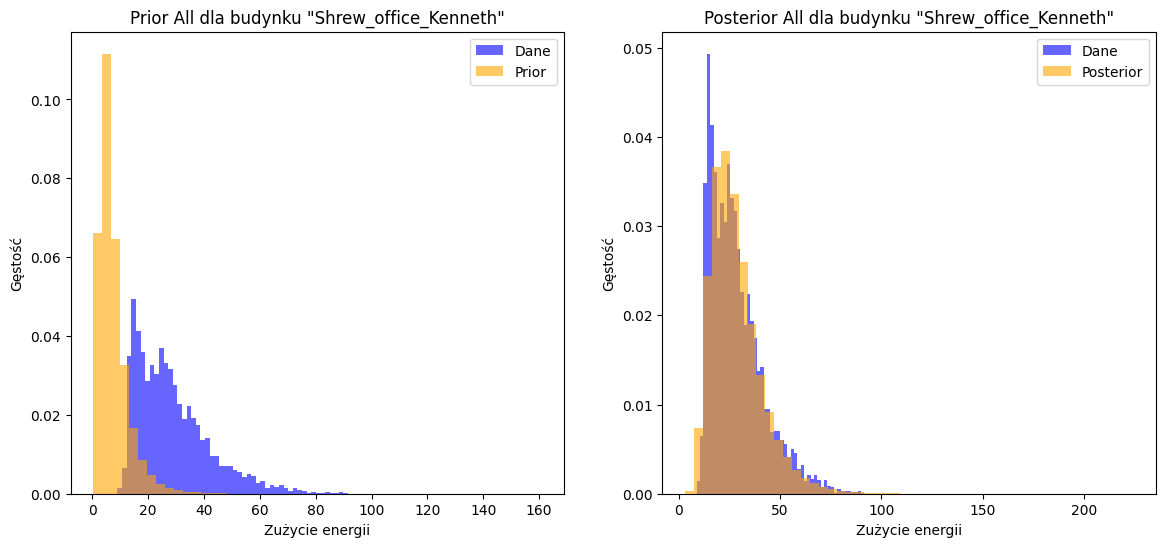

In [83]:
prior_samples = prior_2_all.y_sim.flatten()
posterior_samples = posterior_all.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior All dla budynku "Shrew_office_Kenneth"')

plt.subplot(1, 2, 2)
plt.hist(df_shrew["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior All dla budynku "Shrew_office_Kenneth"')

plt.show()

### Generator

In [116]:
df_shrew["timestamp"].dt.year.iloc[0:3]

24375696    2016
24375697    2016
24375698    2016
Name: timestamp, dtype: int32

In [189]:
df_shrew.head()

timestamp           building_id  energy_consumption  \
24375696 2016-01-01 00:00:00  Shrew_office_Kenneth                10.4   
24375697 2016-01-01 01:00:00  Shrew_office_Kenneth                18.6   
24375698 2016-01-01 02:00:00  Shrew_office_Kenneth                20.0   
24375699 2016-01-01 03:00:00  Shrew_office_Kenneth                18.8   
24375700 2016-01-01 04:00:00  Shrew_office_Kenneth                19.4   

         site_id     sqm       lat       lng       timezone    industry  \
24375696   Shrew  1719.0  51.49984 -0.124663  Europe/London  Government   
24375697   Shrew  1719.0  51.49984 -0.124663  Europe/London  Government   
24375698   Shrew  1719.0  51.49984 -0.124663  Europe/London  Government   
24375699   Shrew  1719.0  51.49984 -0.124663  Europe/London  Government   
24375700   Shrew  1719.0  51.49984 -0.124663  Europe/London  Government   

          yearbuilt  numberoffloors  occupants  airTemperature  
24375696     1937.0             7.0       97.0             3.8  
24375697     1937.0             7.0       97.0             3.7  
24375698     1937.0             7.0       97.0             2.6  
24375699     1937.0             7.0       97.0             2.0  
24375700     1937.0             7.0       97.0             2.3

In [205]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel

# Wybór kolumn
df_seasonal = df_shrew[['energy_consumption', 'airTemperature', 'sqm', 'timestamp',
                        'building_id', 'lat', 'lng', 'numberoffloors', 'occupants', 'yearbuilt']]

# Czasowe cechy
df_seasonal['hour'] = df_seasonal['timestamp'].dt.hour
df_seasonal['day_of_week'] = df_seasonal['timestamp'].dt.dayofweek
df_seasonal['month'] = df_seasonal['timestamp'].dt.month

# Obliczenie średnich i std
scaling_params = {
    'log_sqm': (np.log1p(df_seasonal['sqm']).mean(), np.log1p(df_seasonal['sqm']).std()),
    'temp': (df_seasonal['airTemperature'].mean(), df_seasonal['airTemperature'].std()),
    'lat': (df_seasonal['lat'].mean(), df_seasonal['lat'].std()),
    'lng': (df_seasonal['lng'].mean(), df_seasonal['lng'].std()),
    'yearbuilt': (df_seasonal['yearbuilt'].mean(), df_seasonal['yearbuilt'].std()),
    'numberoffloors': (df_seasonal['numberoffloors'].mean(), df_seasonal['numberoffloors'].std()),
    'occupants': (df_seasonal['occupants'].mean(), df_seasonal['occupants'].std()),
}

# Funkcja skalująca
def scale(x, mean, std):
    return (x - mean) / std if std > 0 else np.zeros_like(x)

# Skalowanie cech
df_seasonal['log_sqm_scaled'] = scale(np.log1p(df_seasonal['sqm']), *scaling_params['log_sqm'])
df_seasonal['temp_scaled'] = scale(df_seasonal['airTemperature'], *scaling_params['temp'])
df_seasonal['lat_scaled'] = scale(df_seasonal['lat'], *scaling_params['lat'])
df_seasonal['lng_scaled'] = scale(df_seasonal['lng'], *scaling_params['lng'])
df_seasonal['yearbuilt_scaled'] = scale(df_seasonal['yearbuilt'], *scaling_params['yearbuilt'])
df_seasonal['numberoffloors_scaled'] = scale(df_seasonal['numberoffloors'], *scaling_params['numberoffloors'])
df_seasonal['occupants_scaled'] = scale(df_seasonal['occupants'], *scaling_params['occupants'])

# Przygotowanie danych dla Stan
data_all_scaling = {
    'N': len(df_seasonal),
    'log_sqm_scaled': df_seasonal['log_sqm_scaled'].values,
    'temp_scaled': df_seasonal['temp_scaled'].values,
    'lat_scaled': df_seasonal['lat_scaled'].values,
    'sqm': df_seasonal['sqm'].values,
    'lat': df_seasonal['lat'].values,
    'lng': df_seasonal['lng'].values,
    'numberoffloors': df_seasonal['numberoffloors'].values,
    'occupants': df_seasonal['occupants'].values,
    'yearbuilt': df_seasonal['yearbuilt'].values,
    'temp': df_seasonal['airTemperature'].values,
    'lng_scaled': df_seasonal['lng_scaled'].values,
    'yearbuilt_scaled': df_seasonal['yearbuilt_scaled'].values,
    'numberoffloors_scaled': df_seasonal['numberoffloors_scaled'].values,
    'occupants_scaled': df_seasonal['occupants_scaled'].values,
    'hour': df_seasonal['hour'].values,
    'day_of_week': df_seasonal['day_of_week'].values,
    'month': df_seasonal['month'].values,
    'y': df_seasonal['energy_consumption'].values
}

# Wczytanie modelu
model_posterior_all_scaling = CmdStanModel(stan_file='full_data_models/posterior_all_scaling.stan')

# Uruchomienie próbkowania
posterior_all_scaling = model_posterior_all_scaling.sample(
    data=data_all_scaling,
    chains=1,
    iter_sampling=100,
)


00:49:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

01:15:24 - cmdstanpy - INFO - CmdStan done processing.
01:15:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_all_scaling.stan', line 81, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_all_scaling.stan', line 81, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'posterior_all_scaling.stan', line 81, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all_scaling.stan', line 81, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior_all_scaling.stan', line 81, column 4 to column 32)
Consider re-running with show_console=True if the above output is unclear!
01:15:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	C

02:03:27 - cmdstanpy - INFO - Chain [1] start processing
02:03:31 - cmdstanpy - INFO - Chain [1] done processing


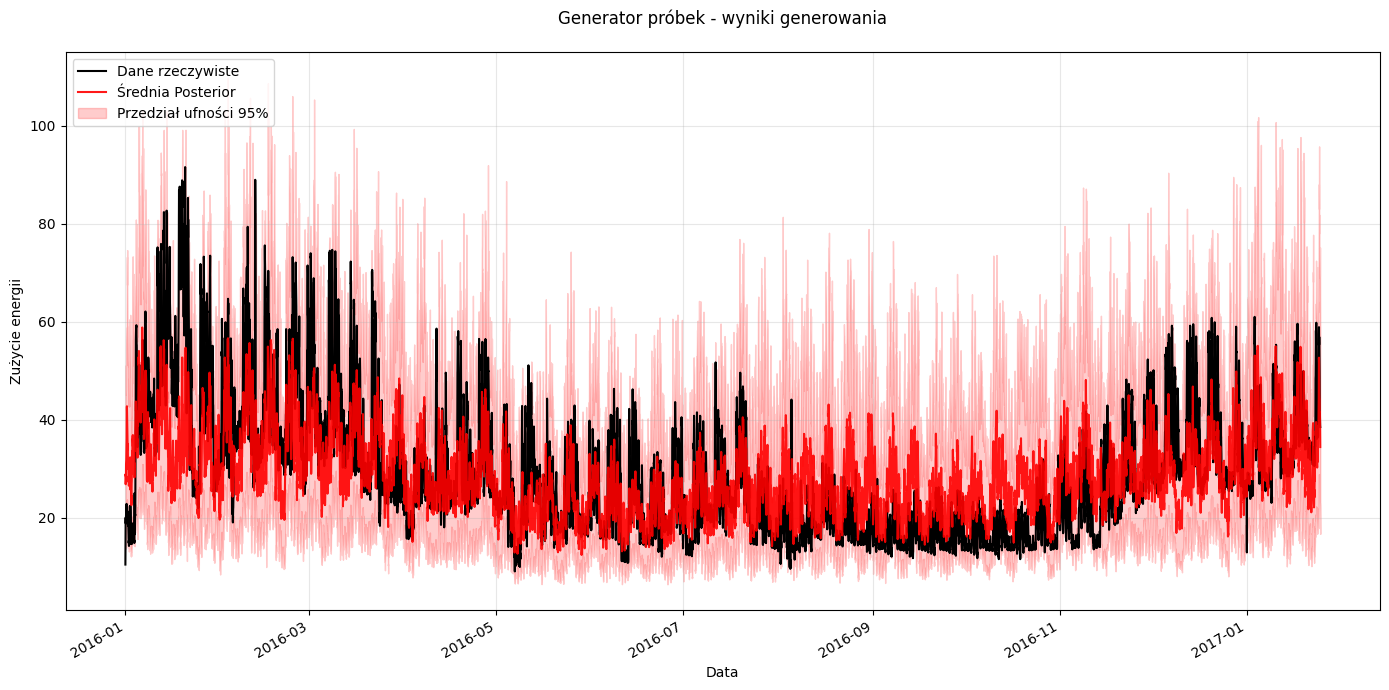

In [238]:
import json
import numpy as np

# ZAKŁADAMY: df_seasonal to pełny zbiór danych, na którym trenowano model
# Oblicz średnie i odchylenia std dla cech ze zbioru treningowego
scaling_params = {
    'log_sqm': (np.log1p(df_seasonal['sqm']).mean(), np.log1p(df_seasonal['sqm']).std()),
    'temp': (df_seasonal['airTemperature'].mean(), df_seasonal['airTemperature'].std()),
    'lat': (df_seasonal['lat'].mean(), df_seasonal['lat'].std()),
    'lng': (df_seasonal['lng'].mean(), df_seasonal['lng'].std()),
    'yearbuilt': (df_seasonal['yearbuilt'].mean(), df_seasonal['yearbuilt'].std()),
    'numberoffloors': (df_seasonal['numberoffloors'].mean(), df_seasonal['numberoffloors'].std()),
    'occupants': (df_seasonal['occupants'].mean(), df_seasonal['occupants'].std()),
}

# Funkcja skalująca
def scale(x, mean, std):
    return (x - mean) / std if std > 0 else np.zeros_like(x)

# Podzbiór danych do generowania
N = len(df_shrew)
start = 0
subset = df_shrew.iloc[start:N]

# Skalowanie cech
log_sqm = np.log1p(subset["sqm"].values)
log_sqm_scaled = scale(log_sqm, *scaling_params['log_sqm'])
temp_scaled = scale(subset["airTemperature"].values, *scaling_params['temp'])
lat_scaled = scale(subset["lat"].values, *scaling_params['lat'])
lng_scaled = scale(subset["lng"].values, *scaling_params['lng'])
yearbuilt_scaled = scale(subset["yearbuilt"].values, *scaling_params['yearbuilt'])
floors_scaled = scale(subset["numberoffloors"].values, *scaling_params['numberoffloors'])
occupants_scaled = scale(subset["occupants"].values, *scaling_params['occupants'])

# Przygotowanie danych wejściowych w formacie Stan
single_point = {
    'N': N - start,
    'log_sqm_scaled': log_sqm_scaled.tolist(),
    'temp_scaled': temp_scaled.tolist(),
    'lat_scaled': lat_scaled.tolist(),
    'lng_scaled': lng_scaled.tolist(),
    'yearbuilt_scaled': yearbuilt_scaled.tolist(),
    'numberoffloors_scaled': floors_scaled.tolist(),
    'occupants_scaled': occupants_scaled.tolist(),
    'hour': subset["timestamp"].dt.hour.values.tolist(),
    'sqm': subset['sqm'].values.tolist(),
    'lat': subset['lat'].values.tolist(),
    'lng': subset['lng'].values.tolist(),
    'numberoffloors': subset['numberoffloors'].values.tolist(),
    'occupants': subset['occupants'].values.tolist(),
    'yearbuilt': subset['yearbuilt'].values.tolist(),
    'temp': subset['airTemperature'].values.tolist(),
    'day_of_week': subset["timestamp"].dt.dayofweek.values.tolist(),
    'month': subset["timestamp"].dt.month.values.tolist(),
    'y': subset["energy_consumption"].values.tolist()  # jeśli model tego potrzebuje
}

# Zapis do JSON
with open("simulate_point.json", "w") as f:
    json.dump(single_point, f)

# Wygenerowanie ilości posteriorowych
sim_result = model_posterior_all_scaling.generate_quantities(
    data="simulate_point.json",
    previous_fit=posterior_all_scaling
)

# Wykres
dates = subset['timestamp'].values 
observed = subset["energy_consumption"].values
simulated = sim_result.y_sim  # shape: (samples, observations)

mean_sim = np.mean(simulated, axis=0)
upper_95 = np.percentile(simulated, 97.5, axis=0)
lower_95 = np.percentile(simulated, 2.5, axis=0)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

plt.plot(dates, observed, 
         color='k', label='Dane rzeczywiste', 
         linewidth=1.5, markersize=1, alpha=1)

plt.plot(dates, mean_sim, color='red', 
         alpha=0.9, label='Średnia Posterior')
plt.fill_between(dates, lower_95, upper_95, 
                color='red', alpha=0.2, 
                label='Przedział ufności 95%')

plt.title('Generator próbek - wyniki generowania', pad=20)
plt.xlabel('Data')
plt.ylabel('Zużycie energii')
plt.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(observed, mean_sim)
rmse = mean_squared_error(observed, mean_sim)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 7.46
RMSE: 98.31


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'energy_consumption'}>,
        <Axes: title={'center': 'sqm'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>,
        <Axes: title={'center': 'yearbuilt'}>],
       [<Axes: title={'center': 'numberoffloors'}>,
        <Axes: title={'center': 'occupants'}>,
        <Axes: title={'center': 'airTemperature'}>]], dtype=object)

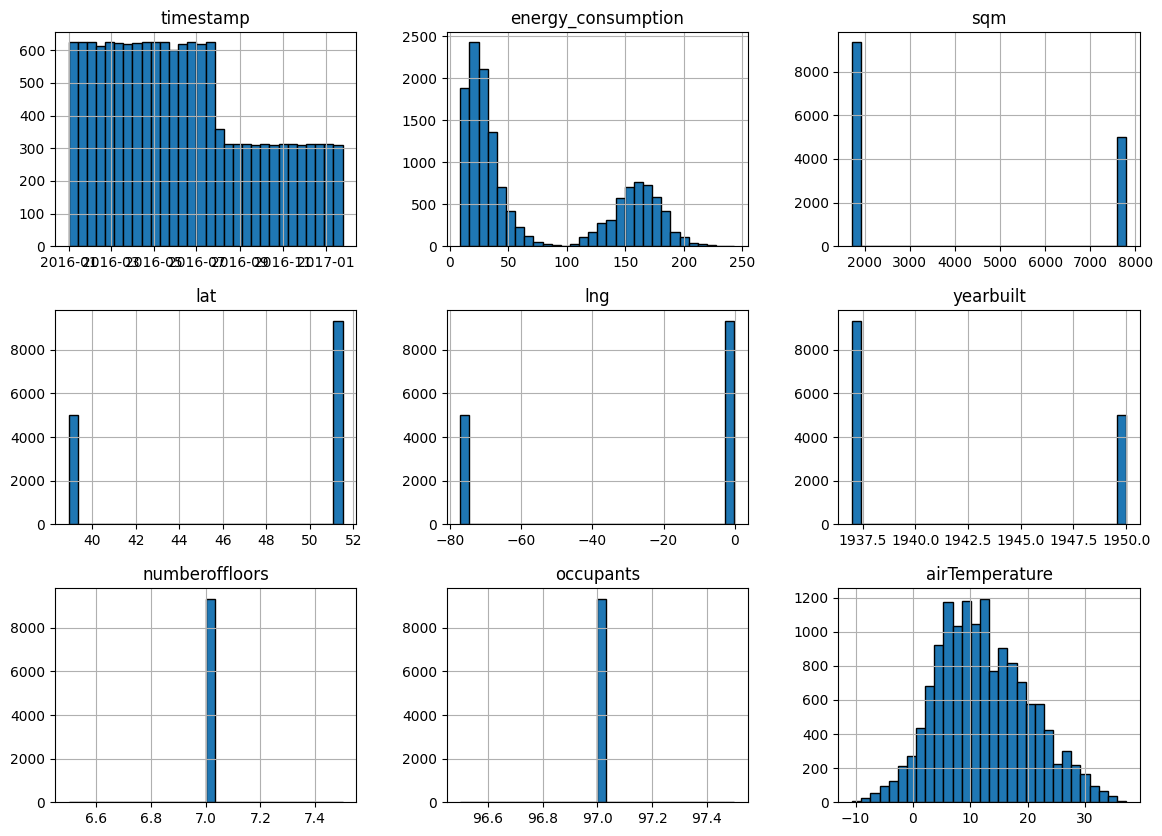

In [244]:
import pandas as pd

# Połączenie DataFrame w pionie (dodanie wierszy)
combined_df = pd.concat([df_shrew, rat_df], ignore_index=True)
combined_df.hist(
    figsize=(14, 10),
    bins=30,
    edgecolor='black',
    layout=(3, 3)  # 3x3 układ wykresów
)

### ADDITIONAL

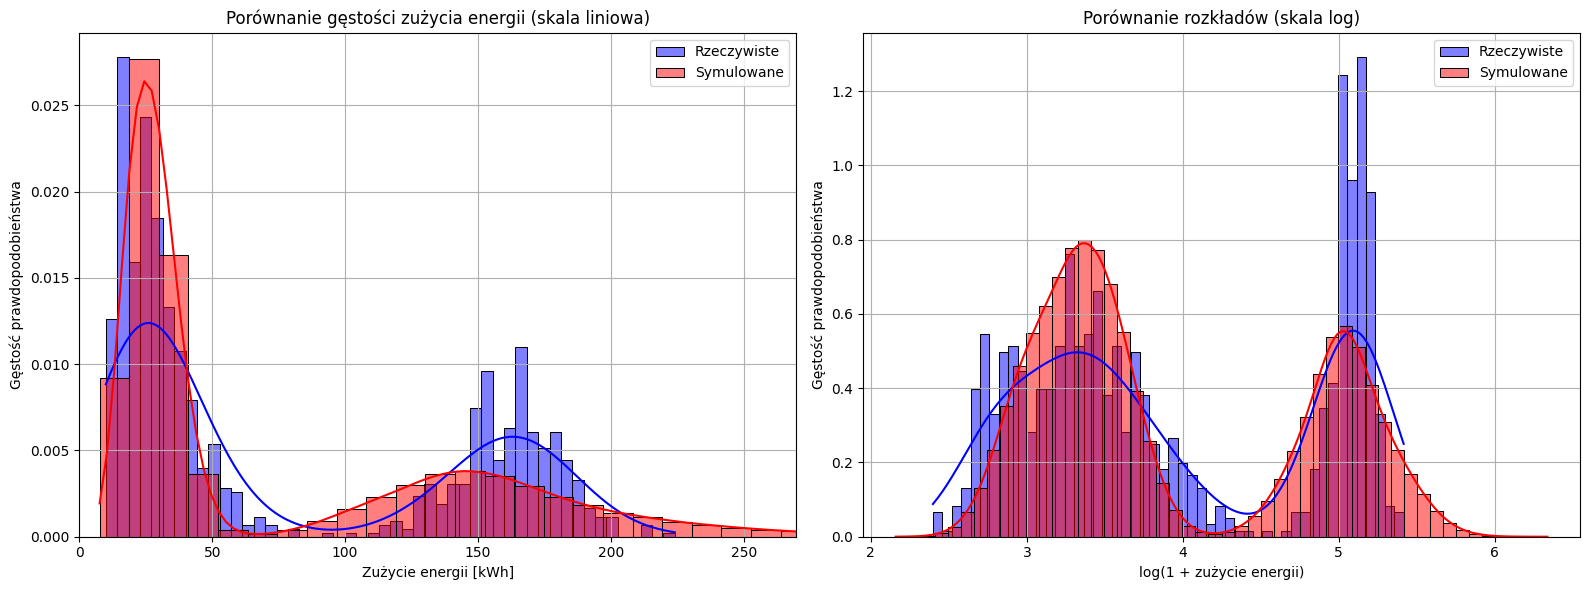

In [298]:

# Ustawienia stylu i rozmiaru wykresów
plt.rcParams['figure.figsize'] = (16, 6)

def calculate_density_comparison(real_data, simulated_data, max_points=10000):
    """
    Funkcja obliczająca i porównująca gęstości rozkładów
    """
    combined_data = np.concatenate([real_data.reshape(-1), simulated_data.reshape(-1)])
    min_val = np.min(combined_data)
    max_val = np.percentile(combined_data, 99.9)
    
    grid = np.linspace(min_val, max_val, 500)
    kde_real = gaussian_kde(real_data)(grid)
    kde_sim = gaussian_kde(simulated_data)(grid)
    
    return grid, kde_real, kde_sim

def simulate_from_prior(sqm, temp, num_samples=1000):
    log_sqm = np.log1p(sqm)
    log_sqm_scaled = (log_sqm - np.mean(log_sqm)) / np.std(log_sqm)
    temp_scaled = (temp - np.mean(temp)) / np.std(temp)
    
    beta0 = np.random.normal(4, 0.01, num_samples)  # Średni poziom zużycia
    beta1 = np.random.normal(1.2, 0.1, num_samples)  # Wpływ powierzchni
    beta2 = np.random.normal(-0.8, 0.4, num_samples) # Wpływ temperatury
    sigma = np.random.lognormal(-2.2, 0.1, num_samples) # Kontrola rozrzutu
    
    mu = beta0[:, None] + \
         beta1[:, None] * np.tanh(log_sqm_scaled) + \
         beta2[:, None] * temp_scaled * np.exp(-temp_scaled**2)  # Lokalne ekstremum
    
    simulated = np.exp(np.random.normal(mu, sigma[:, None]))
    simulated = np.minimum(simulated, 2000) 
    
    return simulated.flatten()

sample_size = 1000
clean_data = combined_df[['energy_consumption',"airTemperature", "sqm","timestamp", "building_id", "lat","lng", "numberoffloors", "occupants", "yearbuilt"]]

if len(clean_data) > sample_size:
    real_sample = clean_data.sample(n=sample_size, random_state=42)
else:
    real_sample = clean_data.copy()

real_energy = real_sample["energy_consumption"].values
sqm = real_sample["sqm"].values
temp = real_sample["airTemperature"].values

simulated_data = simulate_from_prior(sqm, temp)

fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(real_energy, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax1, stat='density', kde=True)
sns.histplot(simulated_data, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax1, stat='density', kde=True)
ax1.set_title('Porównanie gęstości zużycia energii (skala liniowa)')
ax1.set_xlabel('Zużycie energii [kWh]')
ax1.set_ylabel('Gęstość prawdopodobieństwa')
ax1.legend()
ax1.grid(True)

combined = np.concatenate([real_energy, simulated_data])
ax1.set_xlim(0, np.percentile(combined, 99))

log_real = np.log1p(real_energy)
log_sim = np.log1p(simulated_data)

sns.histplot(log_real, bins=50, color='blue', alpha=0.5, 
             label='Rzeczywiste', ax=ax2, stat='density', kde=True)
sns.histplot(log_sim, bins=50, color='red', alpha=0.5, 
             label='Symulowane', ax=ax2, stat='density', kde=True)
ax2.set_title('Porównanie rozkładów (skala log)')
ax2.set_xlabel('log(1 + zużycie energii)')
ax2.set_ylabel('Gęstość prawdopodobieństwa')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [301]:
# Zakładamy, że mamy kolumnę np. "energy"
# df_subset = df_final[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()
df_subset = combined_df[['airTemperature', 'sqm', "energy_consumption", 'building_id']].dropna()

# Creating models
N = len(df_subset)
df_subset = df_subset.iloc[:N]

model_prior = CmdStanModel(stan_file='full_data_models/prior.stan')

temp = df_subset['airTemperature']
sqm	= df_subset['sqm']

# Setting data
data = {'N': N, 'temp': temp, 'sqm': sqm}

# Sampling z priora
prior_1 = model_prior.sample(
    data=data,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=29042020,
    refresh=100,
)

# Odczyt wyników
prior_df = prior_1.draws_pd()
prior_df.head()

data = {'N': N, 'temp': df_subset['airTemperature'], 'sqm': df_subset['sqm'], 'y': df_subset['energy_consumption']}
model_posterior = CmdStanModel(stan_file='full_data_models/posterior.stan')
post_1 = model_posterior.sample(data=data, chains=1, iter_sampling=100)

# Odczyt wyników
posterior_df = post_1.draws_pd()
posterior_df.head()


03:13:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

03:13:13 - cmdstanpy - INFO - CmdStan done processing.


03:13:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

03:13:36 - cmdstanpy - INFO - CmdStan done processing.
03:13:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'posterior.stan', line 41, column 4 to column 32)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positi

chain__  iter__  draw__     lp__  accept_stat__  stepsize__  treedepth__  \
0      1.0     1.0     1.0 -4856.95       0.987307    0.579419          3.0   
1      1.0     2.0     2.0 -4858.91       0.936740    0.579419          3.0   
2      1.0     3.0     3.0 -4857.71       0.990750    0.579419          2.0   
3      1.0     4.0     4.0 -4855.25       0.996309    0.579419          2.0   
4      1.0     5.0     5.0 -4858.40       0.903446    0.579419          3.0   

   n_leapfrog__  divergent__  energy__  ...  log_lik[14329]  log_lik[14330]  \
0           7.0          0.0   4858.02  ...        0.093913        0.115420   
1           7.0          0.0   4860.87  ...        0.083899        0.107213   
2           3.0          0.0   4860.15  ...        0.091559        0.113613   
3           3.0          0.0   4858.17  ...        0.086069        0.108843   
4           7.0          0.0   4859.44  ...        0.113123        0.135074   

   log_lik[14331]  log_lik[14332]  log_lik[14333]  log_lik[14334]  \
0        0.091193        0.095464        0.110655        0.108872   
1        0.082264        0.088926        0.105641        0.103758   
2        0.089941        0.096166        0.111958        0.110181   
3        0.084057        0.089921        0.106167        0.104313   
4        0.110675        0.115574        0.131145        0.129342   

   log_lik[14335]  log_lik[14336]  log_lik[14337]  log_lik[14338]  
0        0.122391        0.129132        0.133282        0.141529  
1        0.119629        0.126693        0.131055        0.140544  
2        0.125033        0.131633        0.135689        0.144405  
3        0.119438        0.126420        0.130728        0.139840  
4        0.143389        0.150137        0.154279        0.162672  

[5 rows x 43028 columns]

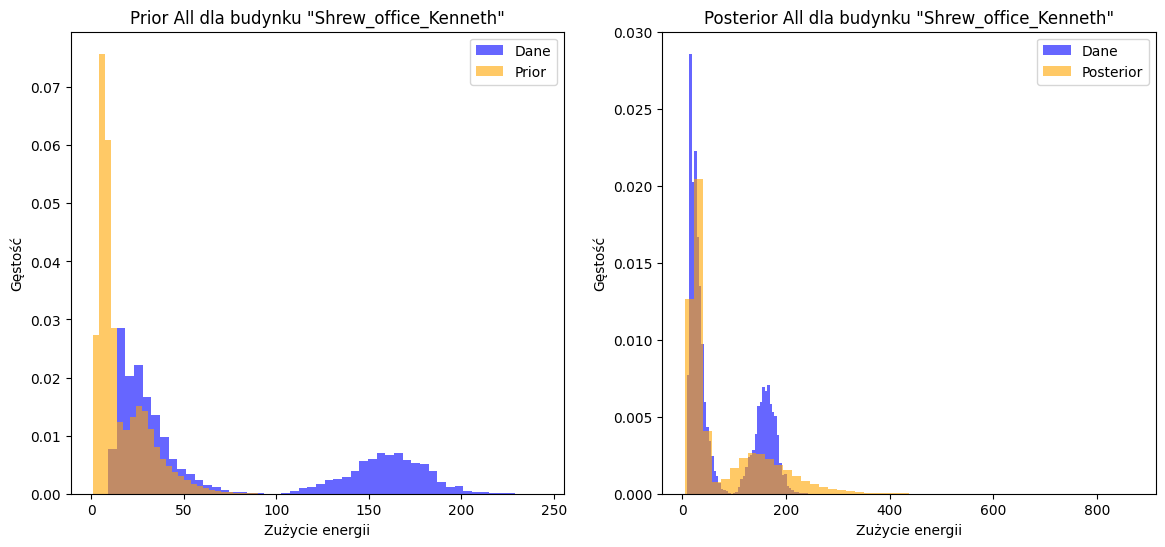

In [303]:
prior_samples = prior_1.y_sim.flatten()
posterior_samples = post_1.y_sim.flatten()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(combined_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(prior_samples, bins=50, alpha=0.6, label="Prior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Prior All dla budynku "Shrew_office_Kenneth"')

plt.subplot(1, 2, 2)
plt.hist(combined_df["energy_consumption"], bins=50, alpha=0.6, label="Dane", color='blue', density=True)
plt.hist(posterior_samples, bins=50, alpha=0.6, label="Posterior", color='orange', density=True)
plt.legend()
plt.xlabel("Zużycie energii")
plt.ylabel("Gęstość")
plt.title('Posterior All dla budynku "Shrew_office_Kenneth"')

plt.show()

In [304]:
pow = az.from_cmdstanpy(
    posterior=post_1,
    posterior_predictive="y_sim"
)
ld = az.loo(pow)
wf = az.waic(pow)

print("LOO:", ld)
print("WAIC:", wf)

LOO: Computed from 100 posterior samples and 14338 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4733.95    86.92
p_loo        3.66        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.50]   (good)     14299   99.7%
   (0.50, 1]   (bad)         39    0.3%
   (1, Inf)   (very bad)     0    0.0%

WAIC: Computed from 100 posterior samples and 14338 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4733.90    86.92
p_waic        3.61        -
